## In this notebook we georeference GEDI and ICESat-2 data


#### Import packages

In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.interpolate import griddata
from shapely.geometry import Point, box
from sliderule import sliderule, icesat2, earthdata
from geoviews import opts, tile_sources as gvts


# import shapely
# import warnings
# import geoviews as gv
# import holoviews as hv
# gv.extension('bokeh', 'matplotlib')
# from geoviews import opts, tile_sources as gvts
# from shapely.errors import ShapelyDeprecationWarning
# warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

#### Loading GEDI Data

In [2]:
gedi_dir_L1B = "/Users/titus/BSU/remote_sensing/carbon_estimation/data/gedi_data/GEDI01_B_002_may21_to_july21/output/"
gedi_dir_L2A = "/Users/titus/BSU/remote_sensing/carbon_estimation/data/gedi_data/GEDI02_A_002_may21_to_july21/output/"
# List of GeoJSON file paths
gediFiles_L1B = [g for g in os.listdir(gedi_dir_L1B) if g.startswith('GEDI01_B') and g.endswith('.geojson')]  # List GEDI L1B .geojson files in the gedi_dir_L1B
gediFiles_L2A = [g for g in os.listdir(gedi_dir_L2A) if g.startswith('GEDI02_A') and g.endswith('.geojson')]  # List GEDI L2A .geojson files in the gedi_dir_L2A

# Load each GeoJSON file and store in a list
gdfs_L1B = [gpd.read_file(gedi_dir_L1B+f'{file}') for file in gediFiles_L1B]
gdfs_L2A = [gpd.read_file(gedi_dir_L2A+f'{file}') for file in gediFiles_L2A]

# Concatenate all GeoDataFrames into a single one
merged_gedi_gdf_L1B = gpd.GeoDataFrame(pd.concat(gdfs_L1B, ignore_index=True))
merged_gedi_gdf_L2A = gpd.GeoDataFrame(pd.concat(gdfs_L2A, ignore_index=True))

# merged_gedi_gdf_L1B = merged_gedi_gdf_L1B.merge(merged_gedi_gdf_L2A[["shot_number", "elev_lowestmode", "rh_100", "geometry", "index"]], left_on=['shot_number_x', 'index'], right_on=['shot_number', 'index'])
merged_gedi_gdf_L1B = merged_gedi_gdf_L1B.merge(merged_gedi_gdf_L2A[["shot_number", "elev_lowestmode", "rh_100", "index"]], left_on=['shot_number_x', 'index'], right_on=['shot_number', 'index'])

# Filter for valid returns 
# merged_gedi_gdf_L1B = merged_gedi_gdf_L1B[(merged_gedi_gdf_L1B['stale_return_flag'] == 0)]
# merged_gedi_gdf_L2A = merged_gedi_gdf_L2A[(merged_gedi_gdf_L2A['stale_return_flag'] == 0)]
# merged_gedi_gdf_L2A = merged_gedi_gdf_L2A[(merged_gedi_gdf_L2A['quality_flag'] == 0)]

# Optional: Set the CRS (if files have the same CRS)
# merged_gedi_gdf_L1B = merged_gedi_gdf_L1B.set_crs("EPSG:4326")  

# print(merged_gedi_gdf_L1B.crs)  # Check the coordinate reference system
print(merged_gedi_gdf_L1B.columns)
print()
print(merged_gedi_gdf_L2A.crs)  # Check the coordinate reference system
print(merged_gedi_gdf_L2A.columns)

# Display first five roles
# merged_gedi_gdf_L1B[['geolocation_elevation_bin0', 'geolocation_elevation_lastbin', 'geolocation_digital_elevation_model', 'geolocation_digital_elevation_model_srtm', 'geolocation_local_beam_elevation']]#.head()
# merged_gedi_gdf_L1B[merged_gedi_gdf_L1B['BEAM'] == 'BEAM0110'][['Latitude', 'Longitude']]
merged_gedi_gdf_L2A[["shot_number", "elev_lowestmode", "rh_100"]]
# merged_gedi_gdf_L2A.columns[:15]



Index(['BEAM', 'shot_number_x', 'Latitude', 'Longitude', 'index',
       'geolocation_degrade', 'geolocation_delta_time',
       'geolocation_digital_elevation_model',
       'geolocation_digital_elevation_model_srtm',
       'geolocation_elevation_bin0', 'geolocation_elevation_lastbin',
       'geolocation_local_beam_elevation', 'geolocation_shot_number',
       'geolocation_solar_elevation', 'land', 'ocean', 'sea_ice', 'land_ice',
       'inland_water', 'noise_mean_corrected', 'rx_sample_count', 'rxwaveform',
       'shot_number_y', 'stale_return_flag', 'tx_sample_count', 'txwaveform',
       'geometry', 'shot_number', 'elev_lowestmode', 'rh_100'],
      dtype='object')

EPSG:4326
Index(['BEAM', 'shot_number', 'Latitude', 'Longitude', 'index', 'degrade_flag',
       'delta_time', 'digital_elevation_model', 'digital_elevation_model_srtm',
       'elev_lowestmode',
       ...
       'rh_97', 'rh_98', 'rh_99', 'rh_100', 'rx_assess_quality_flag',
       'selected_algorithm', 'sensitivity

shot_number  elev_lowestmode  rh_100
0     1.367400e+17        1824.6522    6.21
1     1.367400e+17        1834.6294    6.89
2     1.367400e+17        1845.2205    5.20
3     1.367400e+17        1831.4224   11.19
4     1.367400e+17        1824.0834    5.69
...            ...              ...     ...
4695  1.379611e+17        1594.3878    7.86
4696  1.379611e+17        1597.4028    6.89
4697  1.379611e+17        1599.1685    7.97
4698  1.379611e+17        1597.9299    7.49
4699  1.379611e+17        1593.2203    7.56

[4700 rows x 3 columns]

In [3]:
print("Duplicates", merged_gedi_gdf_L2A['index'].duplicated().sum())
merged_gedi_gdf_L1B.head()

Duplicates 2957


BEAM  shot_number_x   Latitude   Longitude    index  \
0  BEAM0000   1.367400e+17  43.275355 -116.858350  48553.0   
1  BEAM0000   1.367400e+17  43.275075 -116.857764  48554.0   
2  BEAM0000   1.367400e+17  43.274794 -116.857178  48555.0   
3  BEAM0000   1.367400e+17  43.274229 -116.856004  48556.0   
4  BEAM0000   1.367400e+17  43.273944 -116.855416  48557.0   

   geolocation_degrade  geolocation_delta_time  \
0                 30.0            1.060555e+08   
1                 30.0            1.060555e+08   
2                 30.0            1.060555e+08   
3                 30.0            1.060555e+08   
4                 30.0            1.060555e+08   

   geolocation_digital_elevation_model  \
0                            1822.5546   
1                            1839.9299   
2                            1839.9299   
3                            1831.7620   
4                            1816.4551   

   geolocation_digital_elevation_model_srtm  geolocation_elevation_bin0  ...  \
0                                 1828.5452                 1875.331874  ...   
1                                 1833.5460                 1885.046878  ...   
2                                 1847.5469                 1894.214528  ...   
3                                 1841.5486                 1885.772771  ...   
4                                 1825.5497                 1873.564434  ...   

   rx_sample_count                                         rxwaveform  \
0            777.0  244.89145,245.03194,245.13493,245.09036,244.72...   
1            773.0  241.91899,240.81058,240.27328,240.83836,242.40...   
2            756.0  244.35588,243.70148,242.91617,242.37798,242.32...   
3            807.0  245.00339,245.17142,245.26385,245.3838,245.635...   
4            765.0  243.94188,243.95908,244.0793,244.4752,245.2990...   

   shot_number_y  stale_return_flag  tx_sample_count  \
0   1.367400e+17                0.0            128.0   
1   1.367400e+17                0.0            128.0   
2   1.367400e+17                0.0            128.0   
3   1.367400e+17                0.0            128.0   
4   1.367400e+17                0.0            128.0   

                                          txwaveform  \
0  248.03163,248.02585,247.11612,245.7446,244.461...   
1  244.31273,244.18874,243.89453,243.62218,243.56...   
2  242.68015,242.85461,243.39752,243.88388,243.90...   
3  241.0391,240.80544,241.61176,243.1641,244.8435...   
4  246.17552,245.88155,244.85631,243.57776,242.55...   

                      geometry   shot_number  elev_lowestmode  rh_100  
0  POINT (-116.85835 43.27536)  1.367400e+17        1824.6522    6.21  
1  POINT (-116.85776 43.27507)  1.367400e+17        1834.6294    6.89  
2  POINT (-116.85718 43.27479)  1.367400e+17        1845.2205    5.20  
3    POINT (-116.856 43.27423)  1.367400e+17        1831.4224   11.19  
4  POINT (-116.85542 43.27394)  1.367400e+17        1824.0834    5.69  

[5 rows x 30 columns]

In [4]:
# merged_gedi_gdf_L2A#['elevation']#[["num_detectedmodes", "rh_100", "quality_flag"]][1:20]#.columns[1:20]

#### Loading ICESat2 Data

In [5]:
icesat2_dir = "/Users/titus/BSU/remote_sensing/carbon_estimation/data/icesat2_data/"
atl03 = icesat2_dir+"rcew_icesat2_atl03_may21_jul21_new.geojson"
atl08 = icesat2_dir+"rcew_icesat2_atl08sr_may21_jul21_new.geojson"
atl03

'/Users/titus/BSU/remote_sensing/carbon_estimation/data/icesat2_data/rcew_icesat2_atl03_may21_jul21_new.geojson'

In [6]:
# Load the ICESat2 GeoJSON file
icesat2_gdf_atl03 = gpd.read_file(atl03)
icesat2_gdf_atl03 = icesat2_gdf_atl03.to_crs(merged_gedi_gdf_L1B.crs) ## Reproject the ICESat2 geometries to the same CRS as the GEDI data
# icesat2_gdf_atl03["geometry"].to_crs("EPSG:4326") # Reproject the ICESat2 geometries to the same CRS as the GEDI data
# icesat2_gdf_atl03.set_crs("EPSG:4326", allow_override=True, inplace=True) # change the CRS without transforming the geometries

# # Load the ICESat2 GeoJSON file
# icesat2_gdf_atl08 = gpd.read_file(atl08)
# icesat2_gdf_atl08 = icesat2_gdf_atl08.to_crs(merged_gedi_gdf_L1B.crs) ## Reproject the ICESat2 geometries to the same CRS as the GEDI data

# merged_icesat2_gdf_atl03 = icesat2_gdf_atl03.merge(icesat2_gdf_atl08[["asr", "gnd_ph_count", "veg_ph_count", "h_te_median", "h_max_canopy", 
#                                                                       "h_min_canopy", "h_mean_canopy", "h_canopy", "canopy_openness", 
#                                                                       "canopy_h_metrics", "segment_id", "extent_id"]], 
#                                                    left_on=["segment_id", "extent_id"], right_on=["segment_id", "extent_id"])


# Check the data
print(icesat2_gdf_atl03.crs)  # Checking the coordinate reference system
print(icesat2_gdf_atl03.columns)

# # Check the data
# print()
# print(icesat2_gdf_atl08.crs)  # Checking the coordinate reference system
# print(icesat2_gdf_atl08.columns)

EPSG:4326
Index(['time', 'pair', 'track', 'segment_dist', 'cycle', 'region', 'rgt',
       'segment_id', 'sc_orient', 'solar_elevation', 'extent_id',
       'background_rate', 'y_atc', 'atl03_cnf', 'height', 'snowcover',
       'relief', 'landcover', 'yapc_score', 'quality_ph', 'atl08_class',
       'x_atc', 'spot', 'Longitude', 'Latitude', 'Easting', 'Northing',
       'geometry'],
      dtype='object')


In [7]:
# merged_icesat2_gdf_atl03 = icesat2_gdf_atl03.merge(icesat2_gdf_atl08[["asr", "gnd_ph_count", "veg_ph_count", "h_te_median", "h_max_canopy", 
#                                                                       "h_min_canopy", "h_mean_canopy", "h_canopy", "canopy_openness", 
#                                                                       "canopy_h_metrics", "segment_id", "time", "geometry", "solar_elevation_x"]], 
#                                                    left_on=["segment_id", "time", "geometry", "solar_elevation"], right_on=["segment_id", "time", "geometry", "solar_elevation_x"])

# merged_icesat2_gdf_atl03[["h_min_canopy", "h_mean_canopy", "h_canopy", "canopy_openness"]]#.describe()

In [8]:
icesat2_gdf_atl03 = icesat2_gdf_atl03[icesat2_gdf_atl03["pair"] == icesat2_gdf_atl03["sc_orient"]]
icesat2_gdf_atl03

time  pair  track  segment_dist  cycle  region  \
186779  2021-05-23 01:47:15.732     1      1  4.794666e+06     11       2   
186780  2021-05-23 01:47:15.732     1      1  4.794666e+06     11       2   
186781  2021-05-23 01:47:15.732     1      1  4.794666e+06     11       2   
186782  2021-05-23 01:47:15.732     1      1  4.794666e+06     11       2   
186783  2021-05-23 01:47:15.732     1      1  4.794666e+06     11       2   
...                         ...   ...    ...           ...    ...     ...   
6662427 2021-07-26 10:58:40.421     1      3  1.527776e+07     12       6   
6662428 2021-07-26 10:58:40.421     1      3  1.527776e+07     12       6   
6662429 2021-07-26 10:58:40.422     1      3  1.527776e+07     12       6   
6662430 2021-07-26 10:58:40.422     1      3  1.527776e+07     12       6   
6662431 2021-07-26 10:58:40.422     1      3  1.527776e+07     12       6   

         rgt  segment_id  sc_orient  solar_elevation  ...  yapc_score  \
186779   905      239091          1        13.380164  ...         255   
186780   905      239091          1        13.380164  ...         255   
186781   905      239091          1        13.380164  ...         255   
186782   905      239091          1        13.380164  ...         255   
186783   905      239091          1        13.380164  ...         255   
...      ...         ...        ...              ...  ...         ...   
6662427  501      762770          1       -14.510961  ...         255   
6662428  501      762770          1       -14.510961  ...         255   
6662429  501      762770          1       -14.510961  ...         255   
6662430  501      762770          1       -14.510961  ...         255   
6662431  501      762770          1       -14.510961  ...         255   

         quality_ph  atl08_class      x_atc  spot   Longitude   Latitude  \
186779            0            4  -2.096669     5 -116.796930  43.070807   
186780            0            4  -2.139811     5 -116.796935  43.070806   
186781            0            4  -2.239627     5 -116.796948  43.070804   
186782            0            4  -2.360429     5 -116.796963  43.070802   
186783            0            4  -2.509612     5 -116.796982  43.070799   
...             ...          ...        ...   ...         ...        ...   
6662427           0            4  11.562917     1 -116.798774  43.060901   
6662428           0            4  12.838056     1 -116.798811  43.060893   
6662429           0            4  15.688747     1 -116.798815  43.060867   
6662430           0            4  16.380989     1 -116.798816  43.060861   
6662431           0            4  17.814636     1 -116.798819  43.060848   

               Easting      Northing                     geometry  
186779   516534.165693  4.768697e+06  POINT (-116.79693 43.07081)  
186780   516533.735346  4.768697e+06  POINT (-116.79694 43.07081)  
186781   516532.713142  4.768697e+06   POINT (-116.79695 43.0708)  
186782   516531.483987  4.768697e+06   POINT (-116.79696 43.0708)  
186783   516529.958231  4.768696e+06   POINT (-116.79698 43.0708)  
...                ...           ...                          ...  
6662427  516386.659587  4.767597e+06   POINT (-116.79877 43.0609)  
6662428  516383.620890  4.767596e+06  POINT (-116.79881 43.06089)  
6662429  516383.308067  4.767593e+06  POINT (-116.79882 43.06087)  
6662430  516383.211757  4.767592e+06  POINT (-116.79882 43.06086)  
6662431  516383.031312  4.767591e+06  POINT (-116.79882 43.06085)  

[2756710 rows x 28 columns]

In [9]:
# merged_icesat2_gdf_atl03["h_canopy"].describe()

In [10]:
print(icesat2_gdf_atl03['rgt'].unique())
# print(merged_icesat2_gdf_atl03.columns)
# merged_icesat2_gdf_atl03.columns

[905 943 463 501]


In [11]:
def reduce_dataframe(gdf, RGT=None, GT=None, track=None, pair=None, cycle=None, beam='', crs=4326):
    # convert coordinate reference system
    D3 = gdf.to_crs(crs)
    # reduce to reference ground track
    if RGT is not None:
        D3 = D3[D3["rgt"] == RGT]
    # reduce to ground track (gt[123][lr]), track ([123]), or pair (l=0, r=1) 
    gtlookup = {icesat2.GT1L: 1, icesat2.GT1R: 1, icesat2.GT2L: 2, icesat2.GT2R: 2, icesat2.GT3L: 3, icesat2.GT3R: 3}
    pairlookup = {icesat2.GT1L: 0, icesat2.GT1R: 1, icesat2.GT2L: 0, icesat2.GT2R: 1, icesat2.GT3L: 0, icesat2.GT3R: 1}
    if GT is not None:
        D3 = D3[(D3["track"] == gtlookup[GT]) & (D3["pair"] == pairlookup[GT])]
    if track is not None:
        D3 = D3[D3["track"] == track]
    if pair is not None:
        D3 = D3[D3["pair"] == pair]
    # reduce to weak or strong beams
    # tested on cycle 11, where the strong beam in the pair matches the spacecraft orientation.
    # Need to check on other cycles
    if (beam == 'strong'):
        D3 = D3[D3['sc_orient'] == D3['pair']]
    elif (beam == 'weak'):
        D3 = D3[D3['sc_orient'] != D3['pair']]
    # reduce to cycle
    if cycle is not None:
        D3 = D3[D3["cycle"] == cycle]
    # otherwise, return both beams
    return D3

In [12]:
beam_type = 'strong'
D3 = reduce_dataframe(icesat2_gdf_atl03, RGT=463, track=1, beam='strong') # RGT=501
D3

time  pair  track  segment_dist  cycle  region  \
3767510 2021-07-23 22:51:02.702     1      1  4.791578e+06     12       2   
3767514 2021-07-23 22:51:02.702     1      1  4.791578e+06     12       2   
3767535 2021-07-23 22:51:02.702     1      1  4.791578e+06     12       2   
3767566 2021-07-23 22:51:02.702     1      1  4.791578e+06     12       2   
3767574 2021-07-23 22:51:02.702     1      1  4.791578e+06     12       2   
...                         ...   ...    ...           ...    ...     ...   
6609780 2021-07-23 22:51:06.623     1      1  4.819417e+06     12       2   
6609781 2021-07-23 22:51:06.623     1      1  4.819417e+06     12       2   
6609782 2021-07-23 22:51:06.623     1      1  4.819417e+06     12       2   
6609783 2021-07-23 22:51:06.623     1      1  4.819417e+06     12       2   
6609784 2021-07-23 22:51:06.623     1      1  4.819417e+06     12       2   

         rgt  segment_id  sc_orient  solar_elevation  ...  yapc_score  \
3767510  463      238934          1        46.366524  ...         255   
3767514  463      238934          1        46.366524  ...         255   
3767535  463      238934          1        46.366524  ...         255   
3767566  463      238934          1        46.366524  ...         255   
3767574  463      238934          1        46.366524  ...         255   
...      ...         ...        ...              ...  ...         ...   
6609780  463      240323          1        46.300247  ...         255   
6609781  463      240323          1        46.300247  ...         255   
6609782  463      240323          1        46.300247  ...         255   
6609783  463      240323          1        46.300247  ...         255   
6609784  463      240323          1        46.300247  ...         255   

         quality_ph  atl08_class      x_atc  spot   Longitude   Latitude  \
3767510           0            4 -19.858076     5 -116.797498  43.060926   
3767514           0            4 -20.337292     5 -116.797467  43.060923   
3767535           0            4 -18.932104     5 -116.797512  43.060933   
3767566           0            4 -18.859940     5 -116.797472  43.060936   
3767574           0            4 -19.319210     5 -116.797442  43.060934   
...             ...          ...        ...   ...         ...        ...   
6609780           0            0  19.150919     5 -116.828973  43.310761   
6609781           0            4  19.218748     5 -116.828977  43.310762   
6609782           0            0  19.149693     5 -116.828973  43.310761   
6609783           0            4  19.869608     5 -116.829019  43.310765   
6609784           0            4  18.730326     5 -116.828946  43.310759   

               Easting      Northing                     geometry  
3767510  516490.537968  4.767600e+06   POINT (-116.7975 43.06093)  
3767514  516493.044894  4.767600e+06  POINT (-116.79747 43.06092)  
3767535  516489.380233  4.767601e+06  POINT (-116.79751 43.06093)  
3767566  516492.682916  4.767601e+06  POINT (-116.79747 43.06094)  
3767574  516495.078991  4.767601e+06  POINT (-116.79744 43.06093)  
...                ...           ...                          ...  
6609780  513870.949673  4.795339e+06  POINT (-116.82897 43.31076)  
6609781  513870.597184  4.795339e+06  POINT (-116.82898 43.31076)  
6609782  513870.958911  4.795339e+06  POINT (-116.82897 43.31076)  
6609783  513867.177417  4.795339e+06  POINT (-116.82902 43.31076)  
6609784  513873.162195  4.795339e+06  POINT (-116.82895 43.31076)  

[405542 rows x 28 columns]

In [13]:
# plt.figure(figsize=[8,6])

# colors={0:['gray', 'noise'], 
#         4:['gray','unclassified'],  
#         2:['green','canopy'], 
#         3:['lime', 'canopy_top'], 
#         1:['brown', 'ground']}
# d0=np.min(icesat2_gdf_atl03['segment_dist'])
# for class_val, color_name in colors.items():
#     ii=icesat2_gdf_atl03['atl08_class']==class_val
#     plt.plot(icesat2_gdf_atl03['segment_dist'][ii]+icesat2_gdf_atl03['x_atc'][ii]-d0, icesat2_gdf_atl03['height'][ii],'o', 
#          markersize=1, color=color_name[0], label=color_name[1])
# hl=plt.legend(loc=3, frameon=False, markerscale=5)
# # plt.gca().set_xlim([0, 35000])
# # plt.gca().set_ylim([2950, 3150])

# plt.ylabel('height, m')
# plt.xlabel('$x_{ATC}$, m');

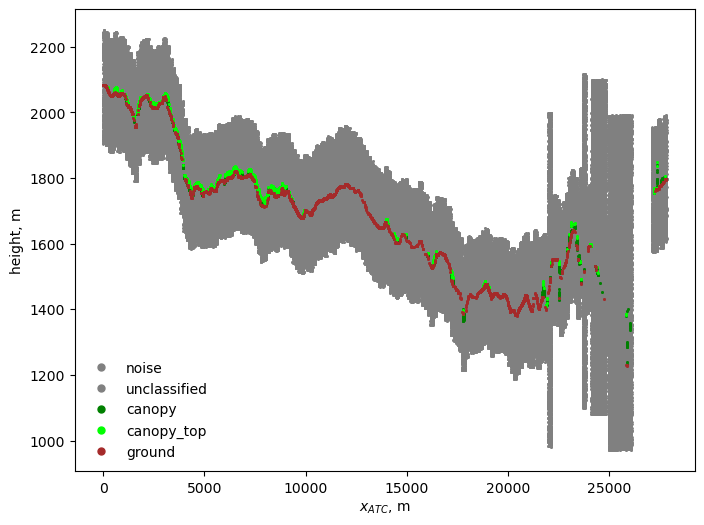

In [14]:
plt.figure(figsize=[8,6])

colors={0:['gray', 'noise'], 
        4:['gray','unclassified'],  
        2:['green','canopy'], 
        3:['lime', 'canopy_top'], 
        1:['brown', 'ground']
        }
d0=np.min(D3['segment_dist'])
for class_val, color_name in colors.items():
    ii=D3['atl08_class']==class_val
    plt.plot(D3['segment_dist'][ii]+D3['x_atc'][ii]-d0, D3['height'][ii],'o', 
         markersize=1, color=color_name[0], label=color_name[1])
hl=plt.legend(loc=3, frameon=False, markerscale=5)
# plt.gca().set_xlim([3500, 4000])
# plt.gca().set_ylim([2950, 3150])

plt.ylabel('height, m')
plt.xlabel('$x_{ATC}$, m')
plt.show();

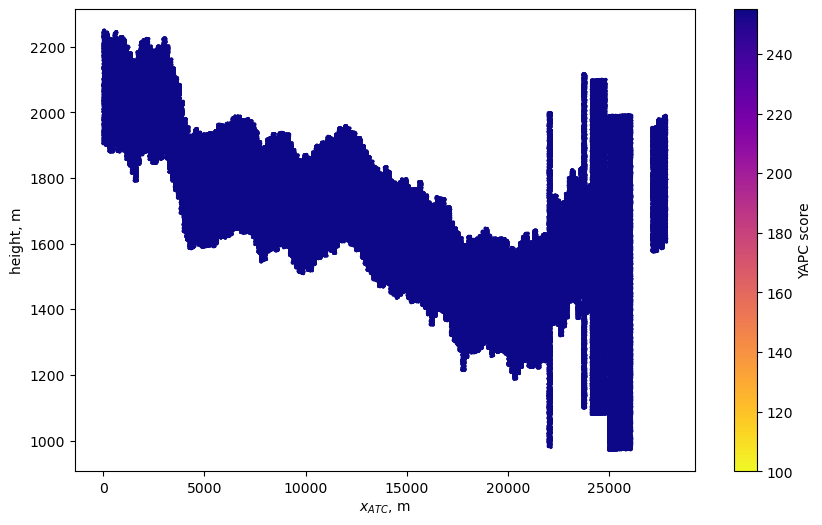

In [15]:
# import matplotlib.pyplot as plt
plt.figure(figsize=[10,6])

d0=np.min(D3['segment_dist'])
ii=np.argsort(D3['yapc_score'])
plt.scatter(D3['segment_dist'].iloc[ii]+D3['x_atc'].iloc[ii]-d0,
    D3['height'].iloc[ii],2, c=D3['yapc_score'].iloc[ii],
    vmin=100, vmax=255, cmap='plasma_r')
plt.colorbar(label='YAPC score')
# plt.gca().set_xlim([26000, 30000])
# plt.gca().set_ylim([2950, 3150])

plt.ylabel('height, m')
plt.xlabel('$x_{ATC}$, m');

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
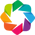

:Overlay
   .Scatter.Noise        :Scatter   [x]   (y)
   .Scatter.Unclassified :Scatter   [x]   (y)
   .Scatter.Canopy       :Scatter   [x]   (y)
   .Scatter.Canopy_top   :Scatter   [x]   (y)
   .Scatter.Ground       :Scatter   [x]   (y)

In [17]:
import shapely
import warnings
import geoviews as gv
import holoviews as hv
gv.extension('bokeh', 'matplotlib')
from geoviews import opts, tile_sources as gvts
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

# Plot Digital Elevation Model
colors={0:['black', 'noise'], 
        4:['gray','unclassified'],  
        2:['green','canopy'], 
        3:['lime', 'canopy_top'], 
        1:['brown', 'ground']
        }
d0=np.min(D3['segment_dist'])





plt.figure(figsize=[14,5])

vis_list = []
for class_val, color_name in colors.items():
    ii=D3['atl08_class']==class_val
    vis_name = color_name[1]+'Vis'
    vis_name = hv.Scatter((D3['segment_dist'][ii]+D3['x_atc'][ii]-d0, D3['height'][ii]), label=color_name[1])
    vis_name = vis_name.opts(color=color_name[0], height=500, width=800, fontsize={'xlabel':16, 'ylabel': 16}, size=1.5)
    vis_list.append(vis_name)

# Combine all three scatterplots
# (vis_list[0] * vis_list[1] * vis_list[2] * vis_list[3] * vis_list[4]).opts(show_legend=True, 
#                                                                            legend_position='top_left',fontsize={'title':14, 'xlabel':16, 'ylabel': 16}, 
#                                                                            title=f'ICESat-2 Photon Classification',
#                                                                            tools=['hover'], xlabel=r"$x_{ATC}$ (m)", ylabel='height (m)')
    
import holoviews as hv
hv.extension('bokeh')

# Assuming vis_list contains HoloViews elements
composite_plot = (vis_list[0] * vis_list[1] * vis_list[2] * vis_list[3] * vis_list[4]).opts(
    show_legend=True,
    legend_position='bottom_left',
    fontsize={'title': 14, 'xlabel': 16, 'ylabel': 16},
    title='ICESat-2 Photon Classification',
    tools=['hover'],
    # xlabel=r"$x_{ATC}$ (m)",
    xlabel=r"x_atc (m)",
    ylabel='elevation (m)'
)

composite_plot

#### Reproject to a Specific Coordinate System.

This step is also optional, but necessary if our analysis requires a particular projection. Though our analysis does not strictly require any specific projection, we will reproject our data to the UMT zone for Boise area in Idaho. This reprojection is the same for our region of interest, Reynolds Creek Experimental Watershed. The ICESat2 data has already been reporjected to the UTM zone for Boise Idaho area. So we will only reproject the GEDI data.

In [16]:
# Reproject to UTM zone for Boise Idaho.
# gedi_gdf = merged_gedi_gdf.to_crs("EPSG:32611")  
# icesat2_gdf = icesat2_gdf.to_crs("EPSG:32611")


#Set utmzone code - utm zone 11:32611
utm_code = 'epsg:32611' 
merged_gedi_gdf_L1B['Longitude'] = merged_gedi_gdf_L1B['geometry'].x
merged_gedi_gdf_L1B['Latitude'] = merged_gedi_gdf_L1B['geometry'].y
eastnorths = merged_gedi_gdf_L1B['geometry'].to_crs(utm_code)
merged_gedi_gdf_L1B['Easting'] = eastnorths.x
merged_gedi_gdf_L1B['Northing'] = eastnorths.y
merged_gedi_gdf_L1B

BEAM  shot_number_x   Latitude   Longitude    index  \
0     BEAM0000   1.367400e+17  43.275355 -116.858350  48553.0   
1     BEAM0000   1.367400e+17  43.275075 -116.857764  48554.0   
2     BEAM0000   1.367400e+17  43.274794 -116.857178  48555.0   
3     BEAM0000   1.367400e+17  43.274229 -116.856004  48556.0   
4     BEAM0000   1.367400e+17  43.273944 -116.855416  48557.0   
...        ...            ...        ...         ...      ...   
4695  BEAM1011   1.379611e+17  43.159896 -116.694867  47689.0   
4696  BEAM1011   1.379611e+17  43.159613 -116.694282  47690.0   
4697  BEAM1011   1.379611e+17  43.159330 -116.693697  47691.0   
4698  BEAM1011   1.379611e+17  43.159047 -116.693112  47692.0   
4699  BEAM1011   1.379611e+17  43.158764 -116.692527  47693.0   

      geolocation_degrade  geolocation_delta_time  \
0                    30.0            1.060555e+08   
1                    30.0            1.060555e+08   
2                    30.0            1.060555e+08   
3                    30.0            1.060555e+08   
4                    30.0            1.060555e+08   
...                   ...                     ...   
4695                  0.0            1.067355e+08   
4696                  0.0            1.067355e+08   
4697                  0.0            1.067355e+08   
4698                  0.0            1.067355e+08   
4699                  0.0            1.067355e+08   

      geolocation_digital_elevation_model  \
0                               1822.5546   
1                               1839.9299   
2                               1839.9299   
3                               1831.7620   
4                               1816.4551   
...                                   ...   
4695                            1600.5699   
4696                            1588.8274   
4697                            1604.0673   
4698                            1604.0673   
4699                            1590.9287   

      geolocation_digital_elevation_model_srtm  geolocation_elevation_bin0  \
0                                    1828.5452                 1875.331874   
1                                    1833.5460                 1885.046878   
2                                    1847.5469                 1894.214528   
3                                    1841.5486                 1885.772771   
4                                    1825.5497                 1873.564434   
...                                        ...                         ...   
4695                                 1599.8124                 1645.863884   
4696                                 1598.8131                 1648.167129   
4697                                 1604.8137                 1650.869366   
4698                                 1597.8143                 1649.668264   
4699                                 1593.8149                 1644.733861   

      ...  shot_number_y  stale_return_flag  tx_sample_count  \
0     ...   1.367400e+17                0.0            128.0   
1     ...   1.367400e+17                0.0            128.0   
2     ...   1.367400e+17                0.0            128.0   
3     ...   1.367400e+17                0.0            128.0   
4     ...   1.367400e+17                0.0            128.0   
...   ...            ...                ...              ...   
4695  ...   1.379611e+17                0.0            128.0   
4696  ...   1.379611e+17                0.0            128.0   
4697  ...   1.379611e+17                0.0            128.0   
4698  ...   1.379611e+17                0.0            128.0   
4699  ...   1.379611e+17                0.0            128.0   

                                             txwaveform  \
0     248.03163,248.02585,247.11612,245.7446,244.461...   
1     244.31273,244.18874,243.89453,243.62218,243.56...   
2     242.68015,242.85461,243.39752,243.88388,243.90...   
3     241.0391,240.80544,241.61176,243.1641,244.8435...   
4     246.17552,245.88155,244.85631,243.57776,242.

#### Plotting data

Below we plot both data sets together. 

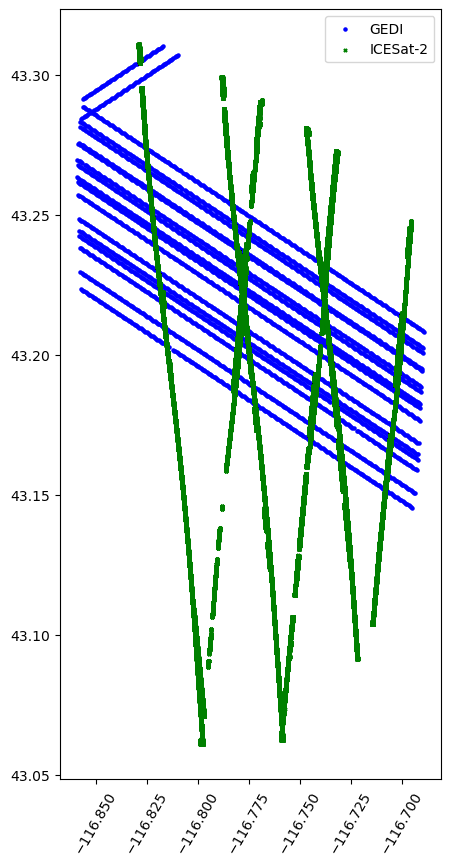

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
merged_gedi_gdf_L1B.plot(ax=ax, marker='o', color='blue', markersize=5, label="GEDI")
icesat2_gdf_atl03.plot(ax=ax, marker='x', color='green', markersize=5, label="ICESat-2")
plt.legend()
plt.xticks(rotation=60)
plt.show()

In [18]:
import matplotlib.pyplot as plt

# Use an interactive backend
%matplotlib qt
fig, ax = plt.subplots(figsize=(12, 12))

# Plot GEDI and ICESat-2 points
merged_gedi_gdf_L1B.plot(ax=ax, marker='o', color='blue', markersize=5, label="GEDI")
icesat2_gdf_atl03.plot(ax=ax, marker='x', color='green', markersize=5, label="ICESat-2")

# Rotate x-axis tick labels
plt.title("GEDI and ICESat-2 Tracks in RCEW")
plt.xlabel("longitude")
plt.xticks(rotation=45)
plt.ylabel("latitude")
plt.legend()
plt.show()


In [19]:
# Specify region of interest shapefile
shp = "/Users/titus/BSU/remote_sensing/tutorials/icesat2/karina/RCEW-outline_WGS84.shp"
shapefile = gpd.read_file(shp)
# shapefile.to_file('DryCreek/boundDCEW/boundDCEW_WGS84.geojson', driver='GeoJSON')
shapefile.crs is None

# Specify region of interest from geojson
poly_fn = '/Users/titus/BSU/remote_sensing/tutorials/icesat2/karina/RCEW-outline_WGS84.geojson'
pregion = gpd.read_file(poly_fn)
region = sliderule.toregion(poly_fn)["poly"] # symplify 
# region

# Prepare coordinate lists for plotting the region of interest polygon
region_lon = [e["lon"] for e in region]
region_lat = [e["lat"] for e in region]

In [22]:
# pregion.plot()

In [20]:
fig, ax = plt.subplots(figsize=(12, 12))
# ax.set_title("ICESat-2 Points")
ax.set_aspect('equal')
# Plot GEDI and ICESat-2 points
# pregion.plot(); #plot origonal boundery 
merged_gedi_gdf_L1B.plot(ax=ax, marker='o', color='blue', markersize=5, label="GEDI")
icesat2_gdf_atl03.plot(ax=ax, marker='x', color='green', markersize=5, label="ICESat-2")
ax.plot(region_lon, region_lat, linewidth=1, color='g');
# plt.legend(fontsize=6, loc="upper right")

# plt.title("GEDI and ICESat-2 Tracks in RCEW")
plt.xlabel("longitude", fontsize = 16)
plt.xticks(rotation=30)
plt.ylabel("latitude", fontsize = 16)
plt.legend()
plt.show()

In [21]:
# fig, ax = plt.subplots(figsize=(12, 12))

# # Set title and aspect ratio
# ax.set_title("GEDI and ICESat-2 Tracks in RCEW")
# ax.set_aspect('equal')

# # Plot the original boundary on the same axes
# pregion.plot(ax=ax, color='none', edgecolor='black', linewidth=1, label="Boundary")

# # Plot GEDI and ICESat-2 points
# merged_gedi_gdf_L1B.plot(ax=ax, marker='o', color='blue', markersize=5, label="GEDI")
# icesat2_gdf_atl03.plot(ax=ax, marker='x', color='green', markersize=5, label="ICESat-2")

# # Plot the simplified region boundary for sanity check
# ax.plot(region_lon, region_lat, linewidth=1, color='g', label="Simplified Region Boundary")

# # Add legend, labels, and formatting
# plt.legend(fontsize=6, loc="upper right")
# plt.xlabel("Longitude")
# plt.xticks(rotation=45)
# plt.ylabel("Latitude")
# plt.show()


In [22]:
# # Define a function for visualizing GEDI points
# def pointVisual(features, vdims):
#     return (gvts.EsriImagery * gv.Points(features, vdims=vdims).options(tools=['hover'], height=500, width=900, size=5, 
#                                                                         color='yellow', fontsize={'xticks': 10, 'yticks': 10, 
#                                                                                                   'xlabel':16, 'ylabel': 16}))
# rcew = gpd.GeoDataFrame.from_file('/Users/titus/BSU/remote_sensing/tutorials/icesat2/karina/RCEW-outline_WGS84_simple.geojson') 

# vdims1 = []
# for f in merged_gedi_gdf_L1B:
#     if f not in ['geometry']:
#         vdims1.append(f)
        
# vdims2 = []
# for f in icesat2_gdf_atl03[icesat2_gdf_atl03['sc_orient'] == icesat2_gdf_atl03['pair']]:
#     if f not in ['geometry']:
#         vdims2.append(f) 

# # visual1 = pointVisual(merged_gedi_gdf_L1B, vdims = vdims1)
# visual2 = pointVisual(icesat2_gdf_atl03[icesat2_gdf_atl03['sc_orient'] == icesat2_gdf_atl03['pair']], vdims = vdims2)
# visual2 * gv.Polygons(rcew['geometry']).opts(line_color='red', color=None)

In [ ]:
# Define a function for visualizing GEDI points
def pointVisual(features, vdims):
    return (gvts.EsriImagery * gv.Points(features, vdims=vdims).options(tools=['hover'], height=500, width=900, size=5, 
                                                                        color='yellow', fontsize={'xticks': 10, 'yticks': 10, 
                                                                                                  'xlabel':16, 'ylabel': 16}))
rcew = gpd.read_file('/Users/titus/BSU/remote_sensing/tutorials/icesat2/karina/RCEW-outline_WGS84_simple.geojson') 

# Use list comprehensions to filter out 'geometry'
vdims1 = [f for f in merged_gedi_gdf_L1B if f != 'geometry']
vdims2 = [f for f in icesat2_gdf_atl03[icesat2_gdf_atl03['sc_orient'] == icesat2_gdf_atl03['pair']] if f != 'geometry']

# Create visualizations
visual1 = pointVisual(merged_gedi_gdf_L1B, vdims=vdims1)
visual2 = pointVisual(icesat2_gdf_atl03[icesat2_gdf_atl03['sc_orient'] == icesat2_gdf_atl03['pair']], vdims=vdims2)
# Combine visualizations and polygons
visual1 * visual2 * gv.Polygons(rcew['geometry']).opts(line_color='red', color=None)

#### Save the Georeferenced Data to GeoJson

In [ ]:
# # Save the data to GeoJSON files
# merged_gedi_gdf_L1B.to_file("gedi_georeferenced.geojson", driver="GeoJSON")
# icesat2_gdf_atl03.to_file("icesat2_georeferenced.geojson", driver="GeoJSON")

#### Computing Vegetation height

The approach here is to compute the difference between the ground elevation and the canopy top elevation.
With the GEDI data, it is quite straight forward. We make use of the following variables in the data:

- `geolocation_elevation_bin0`: This represents the elevation at the beginning of the rx waveform, which is associated with the top of the canopy.
- `geolocation_elevation_lastbin`: This represents the elevation at the end of the rx waveform, which corresponds to the ground level.


For the ICESat-2 data we use two different approaches:
- First, we use the ICESat-2 ATLO8 photon classification to separate canopy top photons from ground photons. We then we group the photons into segments using their segment IDs. In each segment, we take the maximum height of the canopy top photons as the canopy top elevation in that segment. In the same way, in each segment, we take the minimum height of the ground photons as the ground elevation in that segment. We then take the difference between the canopy top elevation and the ground elevation as the vegetation height.
- Second, we use a simpple nearest neighbors approach. For each ground photon, we use the `cKDTree` algorithm to find the nearest canopy top photon. We then take the difference between the heights of the canopy top photon and the ground photon as the vegetation height. 

In [ ]:
# merged_gedi_gdf_L1B['vegetation_height_gedi'] = merged_gedi_gdf_L1B['geolocation_elevation_bin0'] - merged_gedi_gdf_L1B['geolocation_elevation_lastbin']
# merged_gedi_gdf_L1B['vegetation_height_gedi']#.describe()
# merged_gedi_gdf_L1B[['vegetation_height_gedi', 'geolocation_elevation_bin0', 'geolocation_elevation_lastbin']].head()

In [ ]:
# # Filter canopy and ground photons based on `atl08_class`
# # the photon’s ATL08 classification (0: noise, 1: ground, 2: canopy, 3: top of canopy, 4: unclassified)
# canopytop_photons = icesat2_gdf_atl03[icesat2_gdf_atl03['atl08_class'] == 3]  # atl08 classification code for canopy top is 3
# canopy_photons = icesat2_gdf_atl03[icesat2_gdf_atl03['atl08_class'] == 2]  # atl08 classification code for canopy is 3
# ground_photons = icesat2_gdf_atl03[icesat2_gdf_atl03['atl08_class'] == 1]  # atl08 classification code for the ground is 1

# # Group by segment and calculate max canopy height and min ground height for each group
# canopytop_heights = canopytop_photons.groupby('segment_id')['height'].max()
# canopy_heights = canopy_photons.groupby('segment_id')['height'].max()
# ground_heights = ground_photons.groupby('segment_id')['height'].min()

# # Merge canopy and ground heights into a single DataFrame
# vegetation_heights = pd.DataFrame({'canopytop_height': canopytop_heights, 'canopy_height': canopy_heights, 'ground_height': ground_heights})

# # Calculate vegetation height (canopy height - ground height) for each segment
# vegetation_heights['vegetation_height'] = vegetation_heights['canopy_height'] - vegetation_heights['ground_height']

# # Remove rows with NaN values in 'vegetation_height'
# vegetation_heights.dropna(subset=['vegetation_height'], inplace=True)
# # vegetation_heights.fillna(0)

# # Display the vegetation heights
# print(vegetation_heights[['vegetation_height']].describe())
# print(len(canopy_heights), len(ground_heights))


In [23]:
# Filter canopy and ground photons based on `atl08_class`
# the photon’s ATL08 classification (0: noise, 1: ground, 2: canopy, 3: top of canopy, 4: unclassified)
# icesat2_gdf_atl03 = merged_icesat2_gdf_atl03
# The second condition means we are only interested in strong beams
canopytop_photons = icesat2_gdf_atl03[(icesat2_gdf_atl03['atl08_class'] == 3) & (icesat2_gdf_atl03['sc_orient'] == icesat2_gdf_atl03['pair'])]    # Canopy top
canopy_photons = icesat2_gdf_atl03[(icesat2_gdf_atl03['atl08_class'] == 2) & (icesat2_gdf_atl03['sc_orient'] == icesat2_gdf_atl03['pair'])]   # Canopy
ground_photons = icesat2_gdf_atl03[(icesat2_gdf_atl03['atl08_class'] == 1) & (icesat2_gdf_atl03['sc_orient'] == icesat2_gdf_atl03['pair'])]   # Ground

# Group by segment and calculate max canopy top height, max canopy height, and min ground height for each group
canopytop_heights = canopytop_photons.groupby('segment_id')['height'].max()
canopy_heights = canopy_photons.groupby('segment_id')['height'].max()
ground_heights = ground_photons.groupby('segment_id')['height'].min()


# # Group by segment and calculate max canopy top height, max canopy height, and min ground height for each group
# canopytop_heights = pd.DataFrame(canopytop_photons.groupby('segment_id')['height'].max())
# canopy_heights = pd.DataFrame(canopy_photons.groupby('segment_id')['height'].max())
# ground_heights = pd.DataFrame(ground_photons.groupby('segment_id')['height'].min())

# # Perform an outer join on the segment_id column
# merged_df = (
#     canopytop_heights
#     .merge(canopy_heights, on='segment_id', how='outer', suffixes=('_canopytop', '_canopy'))
#     .merge(ground_heights, on='segment_id', how='outer', suffixes=('', '_ground'))
# )

# # Rename the columns for clarity (optional)
# merged_df.columns = ['canopytop_height', 'canopy_height', 'ground_height']

# # Reset index (optional)
# merged_df.reset_index(inplace=True)

# # Display the merged DataFrame
# print(merged_df)




# Merge canopy and ground heights into a single DataFrame
vegetation_heights = pd.DataFrame({
    'canopytop_height': canopytop_heights, 
    'canopy_height': canopy_heights, 
    'ground_height': ground_heights
})

# Calculate vegetation height based on the criteria:
# 1. If canopy top height exists, vegetation height = canopytop_height - ground_height
# 2. Otherwise, if canopy height exists, vegetation height = canopy_height - ground_height
# 3. If neither exists, vegetation height = 0
def calculate_vegetation_height(row):
    if not pd.isna(row['canopytop_height']):
        return row['canopytop_height'] - row['ground_height']
    elif not pd.isna(row['canopy_height']):
        return row['canopy_height'] - row['ground_height']
    else:
        return 0

# Apply the calculation to each row
vegetation_heights['vegetation_height'] = vegetation_heights.apply(calculate_vegetation_height, axis=1)

# Replace NaN vegetation heights (if any exist due to missing canopy top height and canopy height) with 0
vegetation_heights['vegetation_height'] = vegetation_heights['vegetation_height'].fillna(0)


# Display the vegetation heights
print(vegetation_heights[(vegetation_heights['vegetation_height'] >= 0)&(vegetation_heights['vegetation_height'] < 25)].describe())
print(len(canopytop_heights), len(canopy_heights), len(ground_heights))


       canopytop_height  canopy_height  ground_height  vegetation_height
count        597.000000     803.000000    1066.000000        1146.000000
mean        1622.142928    1649.348285    1549.166058           7.187403
std          275.116583     287.826091     315.104638           7.240412
min         1096.963500    1091.278100    1073.463600           0.000000
25%         1377.950000    1399.921500    1227.434175           0.000000
50%         1638.153900    1684.637100    1470.554250           5.757450
75%         1854.251600    1893.671550    1849.224200          12.680850
max         2081.398700    2087.051800    2078.264400          24.986700
1762 2126 2389


In [24]:
# merged_gedi_gdf_L1B["rh_100"].describe()

In [25]:
vegetation_heights = vegetation_heights[(vegetation_heights["vegetation_height"] >= 0)&(vegetation_heights["vegetation_height"] < 30)]
vegetation_heights.describe()

canopytop_height  canopy_height  ground_height  vegetation_height
count        650.000000     857.000000    1120.000000        1200.000000
mean        1613.792513    1642.577268    1546.911476           8.092734
std          283.842557     293.147786     317.512489           8.218532
min         1096.963500    1091.278100    1073.463600           0.000000
25%         1341.739350    1394.649800    1224.044000           0.000000
50%         1636.368650    1663.039300    1468.508100           6.524500
75%         1855.257800    1889.534200    1849.395125          14.248500
max         2082.087600    2087.051800    2078.264400          29.991800

In [26]:
print(icesat2_gdf_atl03.columns, "\n")
# icesat2_gdf_atl08.columns

Index(['time', 'pair', 'track', 'segment_dist', 'cycle', 'region', 'rgt',
       'segment_id', 'sc_orient', 'solar_elevation', 'extent_id',
       'background_rate', 'y_atc', 'atl03_cnf', 'height', 'snowcover',
       'relief', 'landcover', 'yapc_score', 'quality_ph', 'atl08_class',
       'x_atc', 'spot', 'Longitude', 'Latitude', 'Easting', 'Northing',
       'geometry'],
      dtype='object') 



In [27]:
# pd.DataFrame(canopy_heights)
# vegetation_heights#[vegetation_heights["vegetation_height"]>100]
# canopytop_photons[canopytop_photons["segment_id"] == 762642][['time', 'pair', 'track', 'segment_dist', 'cycle', 'region', 'rgt', 'segment_id', 'sc_orient', 'solar_elevation', 'extent_id']]

In [28]:
# # ground_heights
# # 2087.0779-2067.0935
# # 19156 + 63377
# # vegetation_heights[1:50]
# icesat2_gdf_atl08
# # print("Duplicates", icesat2_gdf_atl08['segment_id'].duplicated())#.sum())
# # print(icesat2_gdf_atl08[icesat2_gdf_atl08[['segment_id', 'ph_count']].duplicated(keep=False)])
# icesat2_gdf_atl08[icesat2_gdf_atl08[['segment_id', 'ph_count']].duplicated(keep=False)]
# # icesat2_gdf_atl08[icesat2_gdf_atl08['segment_id'] == 239165]

In [29]:
# import pandas as pd
# from scipy.spatial import cKDTree

# # Separate canopy and ground points
# # The second condition means we are only interested in strong beams
# canopytop_photons = icesat2_gdf_atl03[(icesat2_gdf_atl03['atl08_class'] == 3) & (icesat2_gdf_atl03['sc_orient'] == icesat2_gdf_atl03['pair'])]    # Canopy top
# canopy_photons = icesat2_gdf_atl03[(icesat2_gdf_atl03['atl08_class'] == 2) & (icesat2_gdf_atl03['sc_orient'] == icesat2_gdf_atl03['pair'])]   # Canopy
# ground_photons = icesat2_gdf_atl03[(icesat2_gdf_atl03['atl08_class'] == 1) & (icesat2_gdf_atl03['sc_orient'] == icesat2_gdf_atl03['pair'])]   # Ground

# # Convert latitude and longitude to radians for more accurate distance calculations
# canopytop_coords = np.radians(canopytop_photons[['Latitude', 'Longitude']].values)
# canopy_coords = np.radians(canopy_photons[['Latitude', 'Longitude']].values)
# ground_coords = np.radians(ground_photons[['Latitude', 'Longitude']].values)

# # Create a KDTree for ground points
# ground_tree = cKDTree(ground_coords)

# # Find nearest ground point for each canopy point within a reasonable distance (e.g., 100 meters)
# # Distance in radians (e.g., 100 meters on Earth's surface is approx 0.0009 radians)
# distances, indices = ground_tree.query(canopy_coords, distance_upper_bound=0.0000009)

# # Filter canopy points that have a valid ground point within the distance threshold
# valid_matches = distances != np.inf
# canopytop_photons = canopytop_photons[valid_matches].reset_index(drop=True)
# ground_photons_matched = ground_photons.iloc[indices[valid_matches]].reset_index(drop=True)

# # Calculate vegetation height for each matched canopy-ground pair
# vegetation_heights = canopytop_photons['height'] - ground_photons_matched['height']

# # Add vegetation heights as a new column in the canopy_points DataFrame
# canopytop_photons['vegetation_height'] = vegetation_heights

# # Display results
# print(canopytop_photons[['Latitude', 'Longitude', 'height', 'vegetation_height']].describe())
# icesat2_gdf_atl03_veg_height = canopytop_photons. 
# # canopy_photons[canopy_photons['vegetation_height']>50]

In [30]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree

# Separate canopy and ground points
canopytop_photons = icesat2_gdf_atl03[
    (icesat2_gdf_atl03['atl08_class'] == 3) & 
    (icesat2_gdf_atl03['sc_orient'] == icesat2_gdf_atl03['pair'])
]  # Canopy top

canopy_photons = icesat2_gdf_atl03[
    (icesat2_gdf_atl03['atl08_class'] == 2) & 
    (icesat2_gdf_atl03['sc_orient'] == icesat2_gdf_atl03['pair'])
]  # Canopy

ground_photons = icesat2_gdf_atl03[
    (icesat2_gdf_atl03['atl08_class'] == 1) & 
    (icesat2_gdf_atl03['sc_orient'] == icesat2_gdf_atl03['pair'])
]  # Ground

# Convert latitude and longitude to radians for accurate distance calculations
canopytop_coords = np.radians(canopytop_photons[['Latitude', 'Longitude']].values)
canopy_coords = np.radians(canopy_photons[['Latitude', 'Longitude']].values)
ground_coords = np.radians(ground_photons[['Latitude', 'Longitude']].values)

# Create KDTree for canopy top and canopy photons
canopytop_tree = cKDTree(canopytop_coords)
canopy_tree = cKDTree(canopy_coords)

# Find the nearest canopy top photon to every ground photon
# Distance in radians (e.g., 100 meters on Earth's surface is approx 0.0009 radians)
distances_top, indices_top = canopytop_tree.query(ground_coords, distance_upper_bound=0.0000009)  # ~100 meters

# Find the nearest canopy photon to every ground photon
# Distance in radians (e.g., 100 meters on Earth's surface is approx 0.0009 radians)
distances_canopy, indices_canopy = canopy_tree.query(ground_coords, distance_upper_bound=0.0000009)  # ~100 meters

# Compute vegetation height
vegetation_heights = []
for i, (dist_top, index_top, dist_canopy, index_canopy) in enumerate(
    zip(distances_top, indices_top, distances_canopy, indices_canopy)
):
    if dist_top != np.inf:  # Canopy top photon exists in the neighborhood
        vegetation_height = canopytop_photons.iloc[index_top]['height'] - ground_photons.iloc[i]['height']
    elif dist_canopy != np.inf:  # Fall back to canopy photon
        vegetation_height = canopy_photons.iloc[index_canopy]['height'] - ground_photons.iloc[i]['height']
    else:  # No canopy photon found
        vegetation_height = 0
    vegetation_heights.append(vegetation_height)

# Add vegetation heights as a new column to the ground_photons DataFrame
# ground_photons.loc[:, 'vegetation_height'] = vegetation_heights
icesat2_gdf_atl03_veg_height = ground_photons.copy()
icesat2_gdf_atl03_veg_height['vegetation_height'] = vegetation_heights

# Display results
print(icesat2_gdf_atl03_veg_height[['Latitude', 'Longitude', 'height', 'vegetation_height']])
print(icesat2_gdf_atl03_veg_height[['Latitude', 'Longitude', 'height', 'vegetation_height']].describe())



          Latitude   Longitude     height  vegetation_height
3659297  43.100928 -116.754239  1849.2778            23.9285
3659301  43.100928 -116.754239  1849.2778            23.9285
3659370  43.100845 -116.754250  1850.0808            23.1255
3659372  43.100845 -116.754250  1850.0808            23.1255
3659389  43.100800 -116.754256  1850.9868             2.5902
...            ...         ...        ...                ...
6662008  43.093328 -116.794326  1898.3132             0.3294
6662013  43.090754 -116.794628  1898.2217             4.5797
6662014  43.090729 -116.794631  1900.7241             0.0000
6662027  43.090493 -116.794660  1902.1570             3.7623
6662028  43.090493 -116.794660  1902.1570             3.7623

[59951 rows x 4 columns]
           Latitude     Longitude        height  vegetation_height
count  59951.000000  59951.000000  59951.000000       59951.000000
mean      43.165297   -116.754586   1547.054152           1.544562
std        0.056372      0.035046    297.

In [31]:
# canopy_photons = 
# canopy_photons['vegetation_height'].describe()
icesat2_gdf_atl03_veg_height = icesat2_gdf_atl03_veg_height[(icesat2_gdf_atl03_veg_height["vegetation_height"] > 0)&(icesat2_gdf_atl03_veg_height["vegetation_height"] < 25)]
icesat2_gdf_atl03_veg_height["vegetation_height"].describe()

count    24857.000000
mean         3.540725
std          4.333861
min          0.000800
25%          0.863300
50%          1.794200
75%          4.070700
max         24.988600
Name: vegetation_height, dtype: float64

## Computing slope.

Here, we use the difference in elevation and coordinates between successive point to compute the slope between those points. To calculate the slope between successive points,  we will calculate the rate of change in elevation over distance between points in the data. Thus, we will compute the change in elevation (rise) and the change in horizontal distance (run) between each consecutive point. Finally, the slope is the ratio of the two, rise/run.

In [32]:
# Extract coordinates and elevation data for GEDI
latitudes_gedi = merged_gedi_gdf_L1B['Latitude'][:]
longitudes_gedi = merged_gedi_gdf_L1B['Longitude'][:]
elevations_gedi = merged_gedi_gdf_L1B['geolocation_digital_elevation_model'][:] 

# # Extract coordinates and elevation data for ICESat-2
# latitudes_icesat2 = icesat2_gdf_atl03['Latitude'][:]
# longitudes_icesat2 = icesat2_gdf_atl03['Longitude'][:]
# elevations_icesat2 = icesat2_gdf_atl03['height'][:]

# Extract coordinates and elevation data for ICESat-2
latitudes_icesat2 = icesat2_gdf_atl03_veg_height['Latitude'][:]
longitudes_icesat2 = icesat2_gdf_atl03_veg_height['Longitude'][:]
elevations_icesat2 = icesat2_gdf_atl03_veg_height['height'][:]

# Create GEDI GeoDataFrame
gedi_points = [Point(lon, lat) for lon, lat in zip(longitudes_gedi, latitudes_gedi)]
gedi_gdf2 = gpd.GeoDataFrame({'elevation': elevations_gedi}, geometry=gedi_points, crs="EPSG:4326")

# Create ICESat-2 GeoDataFrame
icesat2_points = [Point(lon, lat) for lon, lat in zip(longitudes_icesat2, latitudes_icesat2)]
icesat2_gdf2 = gpd.GeoDataFrame({'elevation': elevations_icesat2}, geometry=icesat2_points, crs="EPSG:4326")


In [33]:
from math import radians, cos, sin, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Earth radius in meters
    phi1, phi2 = radians(lat1), radians(lat2)
    delta_phi = radians(lat2 - lat1)
    delta_lambda = radians(lon2 - lon1)

    a = sin(delta_phi / 2) ** 2 + cos(phi1) * cos(phi2) * sin(delta_lambda / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# Calculate slope for GEDI data
gedi_slopes = []
for i in range(1, len(gedi_gdf2)):
    dist = haversine(latitudes_gedi.iloc[i-1], longitudes_gedi.iloc[i-1], latitudes_gedi.iloc[i], longitudes_gedi.iloc[i])
    delta_elevation = elevations_gedi.iloc[i] - elevations_gedi.iloc[i-1]
    slope = delta_elevation / dist if dist != 0 else 0
    gedi_slopes.append(slope)

# Calculate slope for ICESat-2 data
icesat2_slopes = []
for i in range(1, len(icesat2_gdf2)):
    dist = haversine(latitudes_icesat2.iloc[i-1], longitudes_icesat2.iloc[i-1], latitudes_icesat2.iloc[i], longitudes_icesat2.iloc[i])
    delta_elevation = elevations_icesat2.iloc[i] - elevations_icesat2.iloc[i-1]
    slope = delta_elevation / dist if dist != 0 else 0
    icesat2_slopes.append(slope)


In [34]:
# len(icesat2_slopes)
# icesat2_slopes

In [35]:
from math import atan2, degrees

degrees(int(icesat2_slopes[0]))

0.0

In [36]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from math import atan2, degrees

# gedi_gdf3 and icesat2_gdf3 already contain points with a projected CRS (e.g., UTM)
gedi_gdf3 = gedi_gdf2.to_crs("EPSG:32611")  # Change to a projected CRS for easier distance calculation
icesat2_gdf3 = icesat2_gdf2.to_crs("EPSG:32611")
# icesat2_gdf3 = canopy_photons.to_crs("EPSG:32611")

# Function to calculate slope between points
def calculate_slope(gdf):
    slopes = []
    for i in range(len(gdf) - 1):
        # Get current and next points
        point1 = gdf.iloc[i].geometry
        point2 = gdf.iloc[i + 1].geometry
        
        # Calculate horizontal distance in meters
        horizontal_distance = point1.distance(point2)
        
        # Calculate elevation difference
        elevation_diff = gdf.iloc[i + 1].elevation - gdf.iloc[i].elevation
        
        # Calculate slope in degrees
        slope = degrees(atan2(elevation_diff, horizontal_distance))
        slopes.append(slope)
    
    # Append NaN for the last point (since there’s no slope calculation for the final point)
    slopes.append(np.nan)
    
    # Add slope to the GeoDataFrame
    gdf['slope'] = slopes
    return gdf

# Calculate slope for GEDI data
gedi_gdf = calculate_slope(gedi_gdf3)

# Calculate slope for ICESat-2 data
icesat2_gdf = calculate_slope(icesat2_gdf3)

print(gedi_gdf[['elevation', 'slope']].head())
print(icesat2_gdf[['elevation', 'slope']].head())


   elevation      slope
0  1822.5546  17.002529
1  1839.9299   0.000000
2  1839.9299  -4.094309
3  1831.7620 -14.984878
4  1816.4551  12.518704
         elevation      slope
3659297  1849.2778   0.000000
3659301  1849.2778   4.948102
3659370  1850.0808   0.000000
3659372  1850.0808  10.282828
3659389  1850.9868   0.000000


#### Topographic Influence on Vegetation Height

In [37]:
merged_gedi_gdf_L1B[['rh_100']].describe()

rh_100
count  4700.000000
mean      5.599047
std       2.462468
min       0.000000
25%       3.850000
50%       4.900000
75%       6.597500
max      21.610001

In [38]:
merged_gedi_gdf_L1B["slope"] = gedi_gdf["slope"]
# correlation = merged_gedi_gdf_L1B[['rh_100', 'slope', 'geolocation_digital_elevation_model']].corr()
correlation_gedi = merged_gedi_gdf_L1B[['rh_100', 'slope', 'elev_lowestmode']].corr()
print(correlation_gedi)

                   rh_100     slope  elev_lowestmode
rh_100           1.000000 -0.119199         0.397088
slope           -0.119199  1.000000        -0.126978
elev_lowestmode  0.397088 -0.126978         1.000000


In [39]:
icesat2_gdf_atl03_veg_height["slope"] = icesat2_gdf["slope"]
correlation = icesat2_gdf_atl03_veg_height[['height', 'slope', 'vegetation_height']].corr()
print(correlation)

                     height     slope  vegetation_height
height             1.000000 -0.002530           0.245983
slope             -0.002530  1.000000           0.014446
vegetation_height  0.245983  0.014446           1.000000


In [40]:
# icesat2_gdf_atl03_veg_height["slope"]

#### Vegetation Height Distribution

In [41]:
# Create subplots for GEDI and ICESat-2 histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# GEDI histogram
axes[0].hist(merged_gedi_gdf_L1B['rh_100'], bins=50, color='green', alpha=0.7)
axes[0].set_title('GEDI Vegetation Height Distribution')
axes[0].set_xlabel('Vegetation Height (m)')
axes[0].set_ylabel('Frequency')

# ICESat-2 histogram
axes[1].hist(icesat2_gdf_atl03_veg_height['vegetation_height'], bins=50, color='blue', alpha=0.7)
axes[1].set_title('ICESat-2 Vegetation Height Distribution')
axes[1].set_xlabel('Vegetation Height (m)')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [42]:
# Histogram of vegetation height for both GEDI and ICESat-2
plt.figure(figsize=(10, 6))

# GEDI histogram
merged_gedi_gdf_L1B['rh_100'].hist(bins=50, color='green', alpha=0.7, label='GEDI')

# ICESat-2 histogram
icesat2_gdf_atl03_veg_height['vegetation_height'].hist(bins=50, color='blue', alpha=0.5, label='ICESat-2')

# Add title, labels, and legend
plt.title('Vegetation Height Distribution')
plt.xlabel('Vegetation Height (m)')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()


#### Topographic Influence

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot vegetation height vs elevation
plt.figure(figsize=(10, 6))
axes[0].scatter(merged_gedi_gdf_L1B['elev_lowestmode'], merged_gedi_gdf_L1B['rh_100'], alpha=0.5, c='green')
axes[0].set_title('GEDI Vegetation Height vs Elevation')
axes[0].set_xlabel('Elevation (m)')
axes[0].set_ylabel('Vegetation Height (m)')

axes[1].scatter(icesat2_gdf_atl03_veg_height['height'], icesat2_gdf_atl03_veg_height['vegetation_height'], alpha=0.5, c='green')
axes[1].set_title('ICESat-2 Vegetation Height vs Elevation')
axes[1].set_xlabel('Elevation (m)')
axes[1].set_ylabel('Vegetation Height (m)')

plt.tight_layout()
plt.show()


In [44]:
plt.figure(figsize=(10, 6))
plt.scatter(merged_gedi_gdf_L1B['elev_lowestmode'], merged_gedi_gdf_L1B['rh_100'], alpha=0.7, c="red", label="GEDI")
plt.scatter(icesat2_gdf_atl03_veg_height['height'], icesat2_gdf_atl03_veg_height['vegetation_height'], alpha=0.5, c="green", label="ICESat-2")
plt.title('Vegetation Height vs Elevation')
plt.xlabel('Elevation (m)')
plt.ylabel('Vegetation Height (m)')
plt.legend()
plt.show()

#### Landscape Fragmentation

In [52]:
from shapely.geometry import box

# Define grid parameters
grid_size = 0.009  # Grid cell size in degrees
minx_gedi, miny_gedi, maxx_gedi, maxy_gedi = merged_gedi_gdf_L1B.total_bounds
x_cells_gedi = np.arange(minx_gedi, maxx_gedi, grid_size)
y_cells_gedi = np.arange(miny_gedi, maxy_gedi, grid_size)

# Create grid cells
grid_cells_gedi = [box(x, y, x + grid_size, y + grid_size) for x in x_cells_gedi for y in y_cells_gedi]
grid_gdf_gedi = gpd.GeoDataFrame({'geometry': grid_cells_gedi}, crs=merged_gedi_gdf_L1B.crs)

# Spatial join: Assign vegetation heights to grid cells
joined = gpd.sjoin(merged_gedi_gdf_L1B, grid_gdf_gedi, predicate='within')

# Calculate statistics for each grid cell
grid_stats_gedi = joined.groupby('index_right')['rh_100'].agg(['mean', 'std', 'min', 'max']).reset_index()

# Merge stats back to grid GeoDataFrame
grid_gdf_gedi = grid_gdf_gedi.merge(grid_stats_gedi, left_index=True, right_on='index_right')

# Plot the mean vegetation height per grid cell
grid_gdf_gedi.plot(column='mean', cmap='YlGn', legend=True, figsize=(12, 8))
# grid_gdf_gedi.plot(column='std', cmap='YlGn', legend=True, figsize=(12, 8))
plt.title('Mean Vegetation Height by Grid Cell')
plt.show()


In [53]:
# Define grid parameters
grid_size = 0.009  # Grid cell size in degrees
minx_icesat2, miny_icesat2, maxx_icesat2, maxy_icesat2 = icesat2_gdf_atl03_veg_height.total_bounds
x_cells_icesat2 = np.arange(minx_icesat2, maxx_icesat2, grid_size)
y_cells_icesat2 = np.arange(miny_icesat2, maxy_icesat2, grid_size)

# Create grid cells
grid_cells_icesat2 = [box(x, y, x + grid_size, y + grid_size) for x in x_cells_icesat2 for y in y_cells_icesat2]
grid_gdf_icesat2 = gpd.GeoDataFrame({'geometry': grid_cells_icesat2}, crs=merged_gedi_gdf_L1B.crs)

# Spatial join: Assign vegetation heights to grid cells
joined = gpd.sjoin(icesat2_gdf_atl03_veg_height, grid_gdf_icesat2, predicate='within')

# Calculate statistics for each grid cell
grid_stats_icesat2 = joined.groupby('index_right')['vegetation_height'].agg(['mean', 'std', 'min', 'max']).reset_index()

# Merge stats back to grid GeoDataFrame
grid_gdf_icesat2 = grid_gdf_icesat2.merge(grid_stats_icesat2, left_index=True, right_on='index_right')

# Plot the mean vegetation height per grid cell
grid_gdf_icesat2.plot(column='mean', cmap='YlGn', legend=True, figsize=(12, 8))
# grid_gdf_gedi.plot(column='std', cmap='YlGn', legend=True, figsize=(12, 8))
plt.title('Mean Vegetation Height by Grid Cell')
plt.show()


In [54]:
import matplotlib.pyplot as plt
from shapely.geometry import box
import geopandas as gpd
import numpy as np

# Define grid parameters
grid_size = 0.009  # Grid cell size in degrees

# --- GEDI Grid ---
minx_gedi, miny_gedi, maxx_gedi, maxy_gedi = merged_gedi_gdf_L1B.total_bounds
x_cells_gedi = np.arange(minx_gedi, maxx_gedi, grid_size)
y_cells_gedi = np.arange(miny_gedi, maxy_gedi, grid_size)

# Create grid cells
grid_cells_gedi = [box(x, y, x + grid_size, y + grid_size) for x in x_cells_gedi for y in y_cells_gedi]
grid_gdf_gedi = gpd.GeoDataFrame({'geometry': grid_cells_gedi}, crs=merged_gedi_gdf_L1B.crs)

# Spatial join: Assign vegetation heights to grid cells
joined = gpd.sjoin(merged_gedi_gdf_L1B, grid_gdf_gedi, predicate='within')

# Calculate statistics for each grid cell
grid_stats_gedi = joined.groupby('index_right')['rh_100'].agg(['mean', 'std', 'min', 'max']).reset_index()

# Merge stats back to grid GeoDataFrame
grid_gdf_gedi = grid_gdf_gedi.merge(grid_stats_gedi, left_index=True, right_on='index_right')

# --- ICESat-2 Grid ---
minx_icesat2, miny_icesat2, maxx_icesat2, maxy_icesat2 = icesat2_gdf_atl03_veg_height.total_bounds
x_cells_icesat2 = np.arange(minx_icesat2, maxx_icesat2, grid_size)
y_cells_icesat2 = np.arange(miny_icesat2, maxy_icesat2, grid_size)

# Create grid cells
grid_cells_icesat2 = [box(x, y, x + grid_size, y + grid_size) for x in x_cells_icesat2 for y in y_cells_icesat2]
grid_gdf_icesat2 = gpd.GeoDataFrame({'geometry': grid_cells_icesat2}, crs=merged_gedi_gdf_L1B.crs)

# Spatial join: Assign vegetation heights to grid cells
joined = gpd.sjoin(icesat2_gdf_atl03_veg_height, grid_gdf_icesat2, predicate='within')

# Calculate statistics for each grid cell
grid_stats_icesat2 = joined.groupby('index_right')['vegetation_height'].agg(['mean', 'std', 'min', 'max']).reset_index()

# Merge stats back to grid GeoDataFrame
grid_gdf_icesat2 = grid_gdf_icesat2.merge(grid_stats_icesat2, left_index=True, right_on='index_right')



In [58]:
# # --- Plot Overlay of GEDI and ICESat-2 Grids ---
# fig, ax = plt.subplots(figsize=(12, 8))

# # Plot GEDI grid
# grid_gdf_gedi.plot(ax=ax, column='mean', cmap='YlGn', legend=True, alpha=0.7, edgecolor='green', label='GEDI')

# # Plot ICESat-2 grid
# grid_gdf_icesat2.plot(ax=ax, column='mean', cmap='RdPu', legend=True, alpha=0.7, edgecolor='blue', label='ICESat-2')

# # Customize the plot
# # plt.title('GEDI and ICESat-2 Mean Vegetation Height by Grid Cell', fontsize=16)
# plt.title('GEDI and ICESat-2 Mean Vegetation Height', fontsize=16)
# plt.xlabel('Longitude', fontsize=12)
# plt.ylabel('Latitude', fontsize=12)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.legend(["GEDI", "ICESat-2"])
# plt.show()

In [57]:
# fig, ax = plt.subplots(figsize=(12, 8))

# # Plot GEDI grid
# grid_gdf_gedi.plot(ax=ax, column='mean', cmap='YlGn', legend=True, alpha=0.7, edgecolor='green')
# # Add a proxy artist for GEDI to include it in the legend
# gedi_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', alpha=0.7, markersize=10, label='GEDI')

# # Plot ICESat-2 grid
# grid_gdf_icesat2.plot(ax=ax, column='mean', cmap='RdPu', legend=True, alpha=0.7, edgecolor='blue')
# # Add a proxy artist for ICESat-2 to include it in the legend
# icesat2_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', alpha=0.7, markersize=10, label='ICESat-2')

# # Customize the plot
# plt.title('Mean Vegetation Height', fontsize=16)
# plt.xlabel('Longitude', fontsize=12)
# plt.ylabel('Latitude', fontsize=12)
# plt.xticks(rotation=45)
# plt.tight_layout()

# # Add a custom legend
# ax.legend(handles=[gedi_patch, icesat2_patch], loc='upper right', fontsize=10)

# plt.show()


In [67]:
import matplotlib.pyplot as plt
from shapely.geometry import box
import geopandas as gpd
import numpy as np

# Define grid parameters
grid_size = 0.009  # Grid cell size in degrees

# --- Create Grid Based on GEDI Coordinates ---
minx_gedi, miny_gedi, maxx_gedi, maxy_gedi = merged_gedi_gdf_L1B.total_bounds
x_cells = np.arange(minx_gedi, maxx_gedi, grid_size)
y_cells = np.arange(miny_gedi, maxy_gedi, grid_size)

# Create grid cells
grid_cells = [box(x, y, x + grid_size, y + grid_size) for x in x_cells for y in y_cells]
grid_gdf = gpd.GeoDataFrame({'geometry': grid_cells}, crs=merged_gedi_gdf_L1B.crs)

# --- Assign GEDI Vegetation Heights to Grid Cells ---
joined_gedi = gpd.sjoin(merged_gedi_gdf_L1B, grid_gdf, predicate='within')
gedi_stats = joined_gedi.groupby('index_right')['rh_100'].mean().reset_index()
gedi_stats.rename(columns={'rh_100': 'gedi_mean_height'}, inplace=True)

# --- Assign ICESat-2 Vegetation Heights to the Same Grid Cells ---
joined_icesat2 = gpd.sjoin(icesat2_gdf_atl03_veg_height, grid_gdf, predicate='within')
icesat2_stats = joined_icesat2.groupby('index_right')['vegetation_height'].mean().reset_index()
icesat2_stats.rename(columns={'vegetation_height': 'icesat2_mean_height'}, inplace=True)

# --- Merge GEDI and ICESat-2 Statistics ---
grid_stats = gpd.GeoDataFrame(grid_gdf)
grid_stats = grid_stats.merge(gedi_stats, how='left', left_index=True, right_on='index_right')
grid_stats = grid_stats.merge(icesat2_stats, how='left', left_index=True, right_on='index_right')

# --- Plot Results ---
fig, ax = plt.subplots(figsize=(12, 8))

# Plot GEDI mean heights
grid_stats.plot(ax=ax, column='gedi_mean_height', cmap='YlGn', legend=True, alpha=0.7, edgecolor='black')
gedi_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', alpha=0.7, markersize=10, label='GEDI Mean Height (m)')

# Plot ICESat-2 mean heights
grid_stats.plot(ax=ax, column='icesat2_mean_height', cmap='RdPu', legend=True, alpha=0.7, edgecolor='red')
icesat2_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', alpha=0.7, markersize=10, label='ICESat-2 Mean Height (m)')

# Customize the plot
# plt.title('Mean Vegetation Height', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Add a custom legend
ax.legend(handles=[gedi_patch, icesat2_patch], loc='upper right', fontsize=10)

plt.show()


In [68]:
# joined_gedi.columns
# joined_icesat2.columns
gedi_stats1 = joined_gedi.groupby('index_right')['elev_lowestmode'].mean().reset_index()
gedi_stats2 = joined_gedi.groupby('index_right')['rh_100'].mean().reset_index()


# Merge the two datasets on the "index_right" column
merged_gedi_stats = gedi_stats1.merge(gedi_stats2, on="index_right")

# Compute the correlation
correlation_gedi = merged_gedi_stats["elev_lowestmode"].corr(merged_gedi_stats["rh_100"])
print(f"Correlation between elev_lowestmode and rh_100: {correlation_gedi}")


Correlation between elev_lowestmode and rh_100: 0.6221164928681698


#### Mean elevation across grid

In [ ]:
import matplotlib.pyplot as plt
from shapely.geometry import box
import geopandas as gpd
import numpy as np

# Define grid parameters
grid_size = 0.009  # Grid cell size in degrees

# --- Create Grid Based on GEDI Coordinates ---
minx_gedi, miny_gedi, maxx_gedi, maxy_gedi = merged_gedi_gdf_L1B.total_bounds
x_cells = np.arange(minx_gedi, maxx_gedi, grid_size)
y_cells = np.arange(miny_gedi, maxy_gedi, grid_size)

# Create grid cells
grid_cells = [box(x, y, x + grid_size, y + grid_size) for x in x_cells for y in y_cells]
grid_gdf = gpd.GeoDataFrame({'geometry': grid_cells}, crs=merged_gedi_gdf_L1B.crs)

# --- Assign GEDI Vegetation Heights to Grid Cells ---
joined_gedi = gpd.sjoin(merged_gedi_gdf_L1B, grid_gdf, predicate='within')
gedi_stats = joined_gedi.groupby('index_right')['elev_lowestmode'].std().reset_index()
gedi_stats.rename(columns={'elev_lowestmode': 'gedi_mean_elev'}, inplace=True)

# --- Assign ICESat-2 Vegetation Heights to the Same Grid Cells ---
joined_icesat2 = gpd.sjoin(icesat2_gdf_atl03_veg_height, grid_gdf, predicate='within')
icesat2_stats = joined_icesat2.groupby('index_right')['height'].std().reset_index()
icesat2_stats.rename(columns={'height': 'icesat2_mean_elev'}, inplace=True)

# --- Merge GEDI and ICESat-2 Statistics ---
grid_stats = gpd.GeoDataFrame(grid_gdf)
grid_stats = grid_stats.merge(gedi_stats, how='left', left_index=True, right_on='index_right')
grid_stats = grid_stats.merge(icesat2_stats, how='left', left_index=True, right_on='index_right')

# --- Plot Results ---
fig, ax = plt.subplots(figsize=(12, 8))

# Plot GEDI mean heights
grid_stats.plot(ax=ax, column='gedi_mean_elev', cmap='YlGn', legend=True, alpha=0.7, edgecolor='black')
gedi_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', alpha=0.7, markersize=10, label='GEDI std Elev (m)')

# Plot ICESat-2 mean heights
grid_stats.plot(ax=ax, column='icesat2_mean_elev', cmap='RdPu', legend=True, alpha=0.7, edgecolor='red')
icesat2_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', alpha=0.7, markersize=10, label='ICESat-2 std Elev (m)')

# Customize the plot
# plt.title('Mean Vegetation Height', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Add a custom legend
ax.legend(handles=[gedi_patch, icesat2_patch], loc='upper right', fontsize=10)

plt.show()


In [ ]:
# joined_gedi.columns
# joined_icesat2.columns
icesat2_stats1 = joined_icesat2.groupby('index_right')['height'].mean().reset_index()
icesat2_stats2 = joined_icesat2.groupby('index_right')['vegetation_height'].mean().reset_index()


# Merge the two datasets on the "index_right" column
merged_icesat2_stats = icesat2_stats1.merge(icesat2_stats2, on="index_right")

# Compute the correlation
correlation_icesat2 = merged_icesat2_stats["height"].corr(merged_icesat2_stats["vegetation_height"])
print(f"Correlation between vegetation height and rh_100: {correlation_icesat2}")


In [ ]:
import matplotlib.pyplot as plt
from shapely.geometry import box
import geopandas as gpd
import numpy as np

# Define grid parameters
grid_size = 0.009  # Grid cell size in degrees

# --- Create Grid Based on GEDI Coordinates ---
minx_gedi, miny_gedi, maxx_gedi, maxy_gedi = merged_gedi_gdf_L1B.total_bounds
x_cells = np.arange(minx_gedi, maxx_gedi, grid_size)
y_cells = np.arange(miny_gedi, maxy_gedi, grid_size)

# Create grid cells
grid_cells = [box(x, y, x + grid_size, y + grid_size) for x in x_cells for y in y_cells]
grid_gdf = gpd.GeoDataFrame({'geometry': grid_cells}, crs=merged_gedi_gdf_L1B.crs)

# --- Assign GEDI Vegetation Heights to Grid Cells ---
joined_gedi = gpd.sjoin(merged_gedi_gdf_L1B, grid_gdf, predicate='within')
gedi_stats = joined_gedi.groupby('index_right')['elev_lowestmode'].mean().reset_index()
gedi_stats.rename(columns={'elev_lowestmode': 'gedi_mean_elev'}, inplace=True)

# --- Assign ICESat-2 Vegetation Heights to the Same Grid Cells ---
joined_icesat2 = gpd.sjoin(icesat2_gdf_atl03_veg_height, grid_gdf, predicate='within')
icesat2_stats = joined_icesat2.groupby('index_right')['height'].mean().reset_index()
icesat2_stats.rename(columns={'height': 'icesat2_mean_elev'}, inplace=True)

# --- Merge GEDI and ICESat-2 Statistics ---
grid_stats = gpd.GeoDataFrame(grid_gdf)
grid_stats = grid_stats.merge(gedi_stats, how='left', left_index=True, right_on='index_right')
grid_stats = grid_stats.merge(icesat2_stats, how='left', left_index=True, right_on='index_right')

# --- Plot Results ---
fig, ax = plt.subplots(figsize=(12, 8))

# Plot GEDI mean heights
grid_stats.plot(ax=ax, column='gedi_mean_elev', cmap='YlGn', legend=True, alpha=0.7, edgecolor='black')
gedi_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', alpha=0.7, markersize=10, label='GEDI mean Elev (m)')

# Plot ICESat-2 mean heights
grid_stats.plot(ax=ax, column='icesat2_mean_elev', cmap='RdPu', legend=True, alpha=0.7, edgecolor='red')
icesat2_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', alpha=0.7, markersize=10, label='ICESat-2 Mean Elev (m)')

# Customize the plot
# plt.title('Mean Vegetation Height', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Add a custom legend
ax.legend(handles=[gedi_patch, icesat2_patch], loc='upper right', fontsize=10)

plt.show()


In [64]:
# joined_gedi.columns
# joined_icesat2.columns
icesat2_stats1 = joined_icesat2.groupby('index_right')['height'].mean().reset_index()
icesat2_stats2 = joined_icesat2.groupby('index_right')['vegetation_height'].mean().reset_index()


# Merge the two datasets on the "index_right" column
merged_icesat2_stats = icesat2_stats1.merge(icesat2_stats2, on="index_right")

# Compute the correlation
correlation_icesat2 = merged_icesat2_stats["height"].corr(merged_icesat2_stats["vegetation_height"])
print(f"Correlation between vegetation height and rh_100: {correlation_icesat2}")


Correlation between vegetation height and rh_100: 0.0361086780409603


In [113]:
import matplotlib.pyplot as plt
from shapely.geometry import box
import geopandas as gpd
import numpy as np

# Define grid parameters
grid_size = 0.009  # Grid cell size in degrees

# --- Create Grid Based on ICESat-2 Coordinates ---
minx_icesat2, miny_icesat2, maxx_icesat2, maxy_icesat2 = icesat2_gdf_atl03_veg_height.total_bounds
x_cells = np.arange(minx_icesat2, maxx_icesat2, grid_size)
y_cells = np.arange(miny_icesat2, maxy_icesat2, grid_size)

# Create grid cells
grid_cells = [box(x, y, x + grid_size, y + grid_size) for x in x_cells for y in y_cells]
grid_gdf = gpd.GeoDataFrame({'geometry': grid_cells}, crs=icesat2_gdf_atl03_veg_height.crs)

# --- Assign ICESat-2 Vegetation Heights to Grid Cells ---
joined_icesat2 = gpd.sjoin(icesat2_gdf_atl03_veg_height, grid_gdf, predicate='within')
icesat2_stats = joined_icesat2.groupby('index_right')['vegetation_height'].mean().reset_index()
icesat2_stats.rename(columns={'vegetation_height': 'icesat2_mean_height'}, inplace=True)

# --- Assign GEDI Vegetation Heights to the Same Grid Cells ---
joined_gedi = gpd.sjoin(merged_gedi_gdf_L1B, grid_gdf, predicate='within')
gedi_stats = joined_gedi.groupby('index_right')['rh_100'].mean().reset_index()
gedi_stats.rename(columns={'rh_100': 'gedi_mean_height'}, inplace=True)

# --- Merge GEDI and ICESat-2 Statistics ---
grid_stats = gpd.GeoDataFrame(grid_gdf)
grid_stats = grid_stats.merge(icesat2_stats, how='left', left_index=True, right_on='index_right')
grid_stats = grid_stats.merge(gedi_stats, how='left', left_index=True, right_on='index_right')

# --- Plot Results ---
fig, ax = plt.subplots(figsize=(12, 8))

# Plot ICESat-2 mean heights
grid_stats.plot(ax=ax, column='icesat2_mean_height', cmap='RdPu', legend=True, alpha=0.7, edgecolor='black')
icesat2_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', alpha=0.7, markersize=10, label='ICESat-2 Mean Height')

# Plot GEDI mean heights
grid_stats.plot(ax=ax, column='gedi_mean_height', cmap='YlGn', legend=True, alpha=0.7, edgecolor='red')
gedi_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', alpha=0.7, markersize=10, label='GEDI Mean Height')

# Customize the plot
plt.title('Mean Vegetation Heights for GEDI and ICESat-2 by Grid Cell', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Add a custom legend
ax.legend(handles=[icesat2_patch, gedi_patch], loc='upper right', fontsize=10)

plt.show()


/var/folders/fx/2fdk1gcs15x1chhn56kqjpl40000gp/T/ipykernel_73088/64863193.py:54: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [97]:
import matplotlib.pyplot as plt
from shapely.geometry import box
import geopandas as gpd
import numpy as np

# Define grid parameters
grid_size = 0.009  # Grid cell size in degrees

# Determine the combined bounding box for GEDI and ICESat-2
minx = min(merged_gedi_gdf_L1B.total_bounds[0], icesat2_gdf_atl03_veg_height.total_bounds[0])
miny = min(merged_gedi_gdf_L1B.total_bounds[1], icesat2_gdf_atl03_veg_height.total_bounds[1])
maxx = max(merged_gedi_gdf_L1B.total_bounds[2], icesat2_gdf_atl03_veg_height.total_bounds[2])
maxy = max(merged_gedi_gdf_L1B.total_bounds[3], icesat2_gdf_atl03_veg_height.total_bounds[3])

# Create unified grid cells
x_cells = np.arange(minx, maxx, grid_size)
y_cells = np.arange(miny, maxy, grid_size)
grid_cells = [box(x, y, x + grid_size, y + grid_size) for x in x_cells for y in y_cells]
grid_gdf = gpd.GeoDataFrame({'geometry': grid_cells}, crs=merged_gedi_gdf_L1B.crs)

# Spatial join for GEDI and ICESat-2 data
gedi_joined = gpd.sjoin(merged_gedi_gdf_L1B, grid_gdf, predicate='within')
icesat2_joined = gpd.sjoin(icesat2_gdf_atl03_veg_height, grid_gdf, predicate='within')

# Compute mean vegetation height for GEDI
gedi_stats = gedi_joined.groupby('index_right')['rh_100'].mean().rename('mean_gedi').reset_index()

# Compute mean vegetation height for ICESat-2
icesat2_stats = icesat2_joined.groupby('index_right')['vegetation_height'].mean().rename('mean_icesat2').reset_index()

# Merge statistics into the grid
grid_gdf = grid_gdf.merge(gedi_stats, left_index=True, right_on='index_right', how='left')
grid_gdf = grid_gdf.merge(icesat2_stats, left_index=True, right_on='index_right', how='left')

# Identify cells where only ICESat-2 data is missing
icesat2_missing_cells = grid_gdf[grid_gdf['mean_icesat2'].isna()]

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Plot GEDI data
grid_gdf.plot(ax=ax, column='mean_gedi', cmap='YlGn', legend=True, alpha=0.7, edgecolor='green', label='GEDI')

# Highlight grid cells with missing ICESat-2 data
icesat2_missing_cells.plot(ax=ax, color='red', alpha=0.5, edgecolor='gray', label='ICESat-2 Missing')

# Customize the plot
plt.title('Mean Vegetation Height and ICESat-2 Data Missing', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Add a custom legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', alpha=0.7, markersize=10, label='GEDI'),
    plt.Line2D([0], [0], marker='o', color='red', alpha=0.5, markersize=10, label='ICESat-2 Missing')
]
ax.legend(handles=handles, loc='upper right', fontsize=10)

plt.show()


/var/folders/fx/2fdk1gcs15x1chhn56kqjpl40000gp/T/ipykernel_73088/4068319009.py:61: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


#### Hotspot Analysis

In [109]:
from esda.moran import Moran
from libpysal.weights import Queen

# Create spatial weights
weights_gedi = Queen.from_dataframe(merged_gedi_gdf_L1B, use_index=True)
weights_icesat2 = Queen.from_dataframe(icesat2_gdf_atl03_veg_height, use_index=True)

# Calculate Moran's I
moran_gedi = Moran(merged_gedi_gdf_L1B['rh_100'], weights_gedi)
moran_icesat2 = Moran(icesat2_gdf_atl03_veg_height['vegetation_height'], weights_icesat2)
print(f"Moran's I for GEDI: {moran_gedi.I}")
print(f"Moran's I for ICESat-2: {moran_icesat2.I}")


Moran's I for GEDI: 0.38487845811452226
Moran's I for ICESat-2: 0.5227997804860142


In [110]:
# merged_gedi_gdf_L1B.columns 
# merged_gedi_gdf_L1B["inland_water"]#.columns #== "land_cover"

In [111]:
# Example allometric equation: AGB = 0.05 * (vegetation_height)^2.2
merged_gedi_gdf_L1B['AGB'] = 0.05 * (merged_gedi_gdf_L1B['rh_100'] ** 2.2)

# Estimate carbon stock (assume 50% of biomass is carbon)
merged_gedi_gdf_L1B['carbon_stock'] = merged_gedi_gdf_L1B['AGB'] * 0.5

# Summarize total carbon stock
total_carbon = merged_gedi_gdf_L1B['carbon_stock'].sum()
print(f"Total Carbon Stock: {total_carbon} tons")



Total Carbon Stock: 6578.092400730221 tons


In [112]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(merged_gedi_gdf_L1B['geometry'].x, merged_gedi_gdf_L1B['geometry'].y, merged_gedi_gdf_L1B['rh_100'], c=merged_gedi_gdf_L1B['rh_100'], cmap='YlGn')
ax.set_title('3D Vegetation Height Visualization for GEDI')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Vegetation Height (m)')
plt.show()


/var/folders/fx/2fdk1gcs15x1chhn56kqjpl40000gp/T/ipykernel_89380/1751352918.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [113]:
%matplotlib qt 
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(merged_gedi_gdf_L1B['geometry'].x, 
                     merged_gedi_gdf_L1B['geometry'].y, 
                     merged_gedi_gdf_L1B['rh_100'], 
                     c=merged_gedi_gdf_L1B['rh_100'], 
                     cmap='YlGn')


ax.set_title('3D Vegetation Height Visualization')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Vegetation Height (m)')
plt.show()


/var/folders/fx/2fdk1gcs15x1chhn56kqjpl40000gp/T/ipykernel_89380/3600368125.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [114]:
# import plotly.express as px
# import pandas as pd

# # Prepare the data
# data = pd.DataFrame({
#     'x': merged_gedi_gdf_L1B['geometry'].x,
#     'y': merged_gedi_gdf_L1B['geometry'].y,
#     'z': merged_gedi_gdf_L1B['rh_100'],
#     'color': merged_gedi_gdf_L1B['rh_100']
# })

# # Create a 3D scatter plot
# fig = px.scatter_3d(
#     data,
#     x='x', 
#     y='y', 
#     z='z', 
#     color='color',
#     color_continuous_scale='YlGn',
#     title='3D Vegetation Height Visualization',
#     labels={'x': 'Longitude', 'y': 'Latitude', 'z': 'Vegetation Height (m)'}
# )

# # Show the plot
# fig.show()


In [115]:
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(icesat2_gdf_atl03_veg_height['geometry'].x, 
                     icesat2_gdf_atl03_veg_height['geometry'].y, 
                     icesat2_gdf_atl03_veg_height['vegetation_height'], 
                     c=icesat2_gdf_atl03_veg_height['vegetation_height'], 
                     cmap='YlGn')
ax.set_title('3D Vegetation Height Visualization for ICESat-2')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Vegetation Height (m)')
plt.show()

/var/folders/fx/2fdk1gcs15x1chhn56kqjpl40000gp/T/ipykernel_89380/3855508389.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [ ]:
# merged_gedi_gdf_L1B.plot(column='rh_100', cmap='YlGn', legend=True)


In [116]:
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# # Create a single 3D plot
# fig = plt.figure(figsize=(14, 10))
# ax = fig.add_subplot(111, projection='3d')

# # Plot GEDI data
# scatter1 = ax.scatter(
#     merged_gedi_gdf_L1B['geometry'].x, 
#     merged_gedi_gdf_L1B['geometry'].y, 
#     merged_gedi_gdf_L1B['rh_100'], 
#     c=merged_gedi_gdf_L1B['rh_100'], 
#     cmap='YlGn', 
#     label='GEDI'
# )

# # Plot ICESat-2 data
# scatter2 = ax.scatter(
#     canopy_photons['geometry'].x, 
#     canopy_photons['geometry'].y, 
#     canopy_photons['vegetation_height'], 
#     c=canopy_photons['vegetation_height'], 
#     cmap='YlOrBr', 
#     label='ICESat-2'
# )

# # Add title and axis labels
# ax.set_title('3D Vegetation Height Visualization: GEDI and ICESat-2')
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')
# ax.set_zlabel('Vegetation Height (m)')

# # Add a legend
# ax.legend()

# # Show the plot
# plt.show()


In [64]:
%matplotlib qt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Create a single 3D plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the first dataset (GEDI)
scatter1 = ax.scatter(
    merged_gedi_gdf_L1B['geometry'].x, 
    merged_gedi_gdf_L1B['geometry'].y, 
    merged_gedi_gdf_L1B['rh_100'], 
    c=merged_gedi_gdf_L1B['rh_100'], 
    cmap='YlGn', 
    label='GEDI Vegetation Height'
)

# Plot the second dataset (ICESat-2)
scatter2 = ax.scatter(
    icesat2_gdf_atl03_veg_height['geometry'].x, 
    icesat2_gdf_atl03_veg_height['geometry'].y, 
    icesat2_gdf_atl03_veg_height['vegetation_height'], 
    c=icesat2_gdf_atl03_veg_height['vegetation_height'], 
    cmap='YlOrRd', 
    label='ICESat-2 Vegetation Height'
)

# Set titles and labels
ax.set_title('3D Vegetation Height Visualization for GEDI and ICESat-2')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Vegetation Height (m)')

# Add legend
ax.legend()

# Show the plot
plt.show()


/var/folders/fx/2fdk1gcs15x1chhn56kqjpl40000gp/T/ipykernel_73088/2921097252.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


## Combining GEDI and ICESat2 Data

#### Method 1: Spatial Resampling or Aggregation

Here, we divide the ROI into smaller grid cells. We then perform spatially resample or aggregate the data into common spatial grid cells. Here we use a spatial grids of 0.01 degrees over the ROI and then compute the statistic of interest for each grid cells. In our case we use aggregate the values in each grid cell by taking the mean of the data in that cell. In this approach, we use GEDI coordinaates to create a bounding box ROI and then divided it into smaller grid cells.

In [150]:
print(merged_gedi_gdf_L1B.total_bounds)
print(icesat2_gdf_atl03.total_bounds)

[-116.85910844   43.14543868 -116.6890769    43.3102603 ]
[-116.82902437   43.06084814 -116.69523005   43.31092869]


In [151]:
# Define grid parameters
grid_size = 0.005  # a 0.01° grid
# minx, miny, maxx, maxy = icesat2_gdf_atl03.total_bounds
minx, miny, maxx, maxy = merged_gedi_gdf_L1B.total_bounds

# # Create grid cells
x_cells = np.arange(minx, maxx, grid_size)
y_cells = np.arange(miny, maxy, grid_size)
grid_cells = [box(x, y, x + grid_size, y + grid_size) for x in x_cells for y in y_cells]
grid_gdf = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs="EPSG:4326")

# Spatial join GEDI and ICESat-2 points with grid to aggregate
# gedi_aggregated = gpd.sjoin(merged_gedi_gdf_L1B, grid_gdf, predicate='within').groupby('index_right').mean()
# icesat2_aggregated = gpd.sjoin(icesat2_gdf_atl03, grid_gdf, predicate='within').groupby('index_right').mean()

# Perform spatial join
gedi_joined_L1B = gpd.sjoin(merged_gedi_gdf_L1B, grid_gdf, predicate='within')
icesat2_joined_atl03 = gpd.sjoin(icesat2_gdf_atl03, grid_gdf, predicate='within')

# Separate numeric columns
# It is important to retain the 'index_right' column before separating non-numeric columns
# This will make it easier to merge the numeric and non-numeric columns back together.
numeric_columns_gedi_L1B = gedi_joined_L1B.select_dtypes(include=['number']).columns
numeric_columns_icesat2_atl03 = icesat2_joined_atl03.select_dtypes(include=['number']).columns

# Separate non-numeric columns (including 'geometry' and other relevant fields such as rxwaveform)
# In the code below we use drop instead of select_dtypes to keep 'index_right' in non-numeric columns
# Again, this will make it easier to merge the numeric and non-numeric columns back together.
non_numeric_columns_gedi_L1B = gedi_joined_L1B.drop(columns=numeric_columns_gedi_L1B[:-1])
non_numeric_columns_icesat2_atl03 = icesat2_joined_atl03.drop(columns=numeric_columns_icesat2_atl03[:-1])

# Aggregate numeric columns by taking the mean
gedi_aggregated_L1B = gedi_joined_L1B[numeric_columns_gedi_L1B].groupby(gedi_joined_L1B['index_right']).mean()
icesat2_aggregated_atl03 = icesat2_joined_atl03[numeric_columns_icesat2_atl03].groupby('index_right').mean()

# Merge the non-numeric columns back with the aggregated results
# Note: We use 'index_right' as the joining key
gedi_aggregated_L1B = gedi_aggregated_L1B.merge(non_numeric_columns_gedi_L1B[non_numeric_columns_gedi_L1B.columns], 
                                        left_index=True, right_on='index_right', how='left')
icesat2_aggregated_atl03 = icesat2_aggregated_atl03.merge(non_numeric_columns_icesat2_atl03[non_numeric_columns_icesat2_atl03.columns], 
                                              left_index=True, right_on='index_right', how='left')

# Remove duplicate rows based on 'index_right'
gedi_aggregated_L1B = gedi_aggregated_L1B.drop_duplicates(subset=['index_right'])
icesat2_aggregated_atl03 = icesat2_aggregated_atl03.drop_duplicates(subset=['index_right'])

# # Convert the results to GeoDataFrames and reattach the geometry from grid_gdf
# gedi_aggregated = gpd.GeoDataFrame(gedi_aggregated, geometry=grid_gdf.geometry.loc[gedi_aggregated['index_right']])
# icesat2_aggregated = gpd.GeoDataFrame(icesat2_aggregated, geometry=grid_gdf.geometry.loc[icesat2_aggregated['index_right']])

# gedi_aggregated = gpd.GeoDataFrame(gedi_aggregated, geometry=grid_gdf.geometry.iloc[gedi_aggregated.index])
# icesat2_aggregated = gpd.GeoDataFrame(icesat2_aggregated, geometry=grid_gdf.geometry.iloc[icesat2_aggregated.index])

# Drop duplicate rows based on 'index_right'
gedi_aggregated_L1B = gedi_aggregated_L1B.drop(columns=['index_right_x', 'index_right_y'], errors='ignore')
icesat2_aggregated_atl03 = icesat2_aggregated_atl03.drop(columns=['index_right_x', 'index_right_y'], errors='ignore')

# Set CRS if necessary
gedi_aggregated_L1B.crs = grid_gdf.crs
icesat2_aggregated_atl03.crs = grid_gdf.crs

In [152]:
print(len(gedi_aggregated_L1B), len(icesat2_aggregated_atl03))

496 189


In [162]:
import matplotlib.pyplot as plt

# Plot grid cells
fig, ax = plt.subplots(figsize=(10, 10))
grid_gdf.boundary.plot(ax=ax, color="gray", linewidth=0.5, label="Grid Cells")

# Plot GEDI points
merged_gedi_gdf_L1B.plot(ax=ax, marker='o', color='blue', markersize=5, alpha=0.6, label="GEDI Points")

# Plot ICESat-2 points
icesat2_gdf_atl03.plot(ax=ax, marker='x', color='green', markersize=5, alpha=0.6, label="ICESat-2 Points")

# Add legend and labels
plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Grid Cells with GEDI and ICESat-2 Points")
plt.show()

# ######################################################################
# ######################################################################
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(10, 10))

# # Plot GEDI and ICESat-2 points
# merged_gedi_gdf_L1B.plot(ax=ax, marker='o', color='blue', markersize=5, label="GEDI")
# icesat2_gdf_atl03.plot(ax=ax, marker='x', color='green', markersize=5, label="ICESat-2")

# # Rotate x-axis tick labels
# plt.xticks(rotation=60)

# # Add legend
# plt.legend()

# # Show plot
# plt.show()


/var/folders/fx/2fdk1gcs15x1chhn56kqjpl40000gp/T/ipykernel_89380/1519100003.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


/Users/titus/miniforge3/envs/carbon/lib/python3.10/site-packages/ipykernel/eventloops.py:145: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  el.exec() if hasattr(el, "exec") else el.exec_()


#### Method 2: Nearest Neighbor Matching

This approach is more suitable to find corresponding GEDI and ICESat-2 points that are geographically very close to each other. With this approach we can match points within a certain radius.

In this approach, we rely on `KDTree` from the `scipy` library. In our approach, we resample ICESat-2 at GEDI points.


In [163]:
# from scipy.spatial import cKDTree

# ### Extract Latitude, Longitude, and Elevation/Height
# # Here we extract the lon/lat and elevation/height for the two data sets

# # For GEDI
# latitudes_gedi = merged_gedi_gdf_L1B['Latitude'][:]
# longitudes_gedi = merged_gedi_gdf_L1B['Longitude'][:]
# elevations_gedi = merged_gedi_gdf_L1B['geolocation_digital_elevation_model'][:] 

# # For ICESat-2
# latitudes_icesat2 = icesat2_gdf_atl03['Latitude'][:]
# longitudes_icesat2 = icesat2_gdf_atl03['Longitude'][:]
# elevations_icesat2 = icesat2_gdf_atl03['height'][:]

# # Create GEDI GeoDataFrame
# gedi_points = [Point(lon, lat) for lon, lat in zip(longitudes_gedi, latitudes_gedi)]
# gedi_gdf2 = gpd.GeoDataFrame({'elevation': elevations_gedi}, geometry=gedi_points, crs="EPSG:4326")

# # Create ICESat-2 GeoDataFrame
# icesat2_points = [Point(lon, lat) for lon, lat in zip(longitudes_icesat2, latitudes_icesat2)]
# icesat2_gdf2 = gpd.GeoDataFrame({'elevation': elevations_icesat2}, geometry=icesat2_points, crs="EPSG:4326")

# # Convert coordinates to arrays for fast processing with KDTree
# gedi_coords = gedi_gdf2.geometry.apply(lambda point: (point.x, point.y)).tolist()
# icesat2_coords = icesat2_gdf2.geometry.apply(lambda point: (point.x, point.y)).tolist()

# # Build KDTree for GEDI data
# gedi_tree = cKDTree(gedi_coords, copy_data = True, balanced_tree = True)

# # Find nearest GEDI neighbors for each ICESat-2 point within a maximum radius (e.g., 100 meters)
# distances, indices = gedi_tree.query(icesat2_coords, distance_upper_bound=5e-5)  # 9e-4 ~100 meters

# # # Filter valid matches within the specified radius
# # # Here we filter out any entries where the index j is not valid (i.e., it falls outside the range of gedi_coords). 
# # # Thus, we filter out any indices that exceed the length of gedi_coords 
# # # and check for np.inf distances (which indicate no match within the distance threshold).
# # matched_points = [(i, j) for i, j in enumerate(indices) if j < len(gedi_coords) and distances[i] != np.inf]

# # # Extract matched points
# # matched_icesat2 = [icesat2_coords[i] for i, j in matched_points]
# # matched_gedi = [gedi_coords[j] for i, j in matched_points]

# # # # Extract matched points
# # # matched_gedi = [gedi_coords[j] for i, j in matched_points]
# # # matched_icesat2 = [icesat2_coords[i] for i, j in matched_points]

# # # Extract elevations
# # gedi_elevations_matched = [gedi_gdf2.iloc[j].elevation for i, j in matched_points]
# # icesat2_elevations_matched = [icesat2_gdf2.iloc[i].elevation for i, j in matched_points]

# # # Create DataFrame with coregistered data
# # coregistered_df = pd.DataFrame({
# #     'gedi_lat': [point[1] for point in matched_gedi],
# #     'gedi_lon': [point[0] for point in matched_gedi],
# #     'icesat2_lat': [point[1] for point in matched_icesat2],
# #     'icesat2_lon': [point[0] for point in matched_icesat2],
# #     'gedi_elevation': gedi_elevations_matched,
# #     'icesat2_elevation': icesat2_elevations_matched
# # })


# # Since the KDTree nearest neighbor approach inherently creates a one-to-many relationship between the points, 
# # it could lead to multiple ICESat-2 points linking to the same GEDI point.
# # Thus, we will sort out only the unique matches, to avoid having duplicate nearest neighbours.

# # Sort matched points by distance and keep only unique GEDI indices
# unique_matches = {}
# for i, (dist, idx) in enumerate(zip(distances, indices)):
#     if idx < len(gedi_coords) and (idx not in unique_matches or dist < unique_matches[idx][0]):
#         unique_matches[idx] = (dist, i)  # Store the minimum distance match for each GEDI point

# # Extract unique matched indices for GEDI and ICESat-2 points
# unique_gedi_indices = [k for k in unique_matches.keys()]
# unique_icesat2_indices = [unique_matches[k][1] for k in unique_matches.keys()]

# # Extract matched coordinates and elevations
# matched_gedi = [gedi_coords[j] for j in unique_gedi_indices]
# matched_icesat2 = [icesat2_coords[i] for i in unique_icesat2_indices]
# gedi_elevations_matched = [gedi_gdf2.iloc[j].elevation for j in unique_gedi_indices]
# icesat2_elevations_matched = [icesat2_gdf2.iloc[i].elevation for i in unique_icesat2_indices]

# # Create DataFrame with unique coregistered data
# coregistered_df = pd.DataFrame({
#     'gedi_lat': [point[1] for point in matched_gedi],
#     'gedi_lon': [point[0] for point in matched_gedi],
#     'icesat2_lat': [point[1] for point in matched_icesat2],
#     'icesat2_lon': [point[0] for point in matched_icesat2],
#     'gedi_elevation': gedi_elevations_matched,
#     'icesat2_elevation': icesat2_elevations_matched
# })


In [164]:
from scipy.spatial import cKDTree
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd
import numpy as np

# # Extract coordinates and elevation data for GEDI
# latitudes_gedi = merged_gedi_gdf_L1B['Latitude'][:]
# longitudes_gedi = merged_gedi_gdf_L1B['Longitude'][:]
# elevations_gedi = merged_gedi_gdf_L1B['geolocation_digital_elevation_model'][:] 

# # Extract coordinates and elevation data for ICESat-2
# latitudes_icesat2 = icesat2_gdf_atl03['Latitude'][:]
# longitudes_icesat2 = icesat2_gdf_atl03['Longitude'][:]
# elevations_icesat2 = icesat2_gdf_atl03['height'][:]

# # Create GEDI GeoDataFrame
# gedi_points = [Point(lon, lat) for lon, lat in zip(longitudes_gedi, latitudes_gedi)]
# gedi_gdf2 = gpd.GeoDataFrame({'elevation': elevations_gedi}, geometry=gedi_points, crs="EPSG:4326")

# Create ICESat-2 GeoDataFrame
icesat2_points = [Point(lon, lat) for lon, lat in zip(longitudes_icesat2, latitudes_icesat2)]
icesat2_gdf2 = gpd.GeoDataFrame({'elevation': elevations_icesat2}, geometry=icesat2_points, crs="EPSG:4326")

# Convert coordinates to arrays for fast processing with KDTree
gedi_coords = gedi_gdf2.geometry.apply(lambda point: (point.x, point.y)).tolist()
icesat2_coords = icesat2_gdf2.geometry.apply(lambda point: (point.x, point.y)).tolist()

# Build KDTree for ICESat-2 data
icesat2_tree = cKDTree(icesat2_coords, copy_data=True, balanced_tree=True)

# Find nearest ICESat-2 neighbors for each GEDI point within a maximum radius (e.g., 100 meters)
distances, indices = icesat2_tree.query(gedi_coords, distance_upper_bound=1e-3)  # ~100 meters

# Filter valid matches within the specified radius
# Here we filter out any entries where the index j is not valid (i.e., it falls outside the range of icesat2_coords). 
# Thus, we filter out any indices that exceed the length of gedi_coords 
# and check for np.inf distances (which indicate no match within the distance threshold).
# matched_points = [(i, j) for i, j in enumerate(indices) if j < len(icesat2_coords) and distances[i] != np.inf]

# # Extract matched points for valid pairs
# matched_icesat2 = [icesat2_coords[j] for i, j in matched_points]
# matched_gedi = [gedi_coords[i] for i, j in matched_points]

# # Extract elevations for matched points
# gedi_elevations_matched = [gedi_gdf2.iloc[i].elevation for i, j in matched_points]
# icesat2_elevations_matched = [icesat2_gdf2.iloc[j].elevation for i, j in matched_points]

# # Create DataFrame with coregistered data
# coregistered_df = pd.DataFrame({
#     'gedi_lat': [point[1] for point in matched_gedi],
#     'gedi_lon': [point[0] for point in matched_gedi],
#     'icesat2_lat': [point[1] for point in matched_icesat2],
#     'icesat2_lon': [point[0] for point in matched_icesat2],
#     'gedi_elevation': gedi_elevations_matched,
#     'icesat2_elevation': icesat2_elevations_matched
# })




# Since the KDTree nearest neighbor approach inherently creates a one-to-many relationship between the points, 
# it could lead to multiple GEDI points linking to the same ICESat-2 point.
# Thus, we will sort out only the unique matches, to avoid having duplicate nearest neighbours.

# Sort matched points by distance and keep only unique GEDI indices
unique_matches = {}
for i, (dist, idx) in enumerate(zip(distances, indices)):
    if idx < len(icesat2_coords) and (idx not in unique_matches or dist < unique_matches[idx][0]):
        unique_matches[idx] = (dist, i)  # Store the minimum distance match for each GEDI point

# Extract unique matched indices for GEDI and ICESat-2 points
unique_icesat2_indices = [k for k in unique_matches.keys()]
unique_gedi_indices = [unique_matches[k][1] for k in unique_matches.keys()]

# Extract matched coordinates and elevations
matched_icesat2 = [icesat2_coords[j] for j in unique_icesat2_indices]
matched_gedi = [gedi_coords[i] for i in unique_gedi_indices]
icesat2_elevations_matched = [icesat2_gdf2.iloc[j].elevation for j in unique_icesat2_indices]
gedi_elevations_matched = [gedi_gdf2.iloc[i].elevation for i in unique_gedi_indices]

# Create DataFrame with unique coregistered data
coregistered_df = pd.DataFrame({
    'gedi_lat': [point[1] for point in matched_gedi],
    'gedi_lon': [point[0] for point in matched_gedi],
    'icesat2_lat': [point[1] for point in matched_icesat2],
    'icesat2_lon': [point[0] for point in matched_icesat2],
    'gedi_elevation': gedi_elevations_matched,
    'icesat2_elevation': icesat2_elevations_matched
})



In [165]:
import matplotlib.pyplot as plt

plt.scatter(coregistered_df['gedi_lon'], coregistered_df['gedi_lat'], label='GEDI', alpha=0.5)
plt.scatter(coregistered_df['icesat2_lon'], coregistered_df['icesat2_lat'], label='ICESat-2', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.title('Coregistered GEDI and ICESat-2 Points')
plt.show()

/var/folders/fx/2fdk1gcs15x1chhn56kqjpl40000gp/T/ipykernel_89380/208705259.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


/Users/titus/miniforge3/envs/carbon/lib/python3.10/site-packages/ipykernel/eventloops.py:145: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  el.exec() if hasattr(el, "exec") else el.exec_()


In [161]:
coregistered_df['elevation_difference'] = coregistered_df['icesat2_elevation'] - coregistered_df['gedi_elevation']
len(coregistered_df['elevation_difference'])

170

In [ ]:
# coregistered_df
# len(matched_points)
# # # Assuming gdf is your GeoDataFrame
# # missing_data_count = coregistered_df.isna().sum()
# # print(missing_data_count)

8468

In [ ]:
# # Interpolating ICESat-2 elevations to GEDI points
# interpolated_icesat2 = griddata(
#     (latitudes_icesat2, longitudes_icesat2),  # ICESat-2 coordinates
#     elevations_icesat2,                      # ICESat-2 elevations
#     (latitudes_gedi, longitudes_gedi),       # Interpolating to GEDI points
#     method='cubic'                         # Other options: 'linear', 'cubic'
# )


In [ ]:
# len(interpolated_icesat2)

In [ ]:
# np.isnan(interpolated_icesat2).sum()

np.int64(1375)

-3380.450991271857

In [ ]:
gedi_gdf

elevation                        geometry      slope
0     1822.5546  POINT (511493.994 4791402.995)  17.002529
1     1839.9299  POINT (511541.579 4791371.937)   0.000000
2     1839.9299  POINT (511589.169 4791340.872)  -4.094309
3     1831.7620  POINT (511684.536 4791278.218) -14.984878
4     1816.4551  POINT (511732.277 4791246.737)  12.518704
...         ...                             ...        ...
4695  1600.5699  POINT (524806.312 4778616.368) -11.643603
4696  1588.8274  POINT (524853.981 4778585.144)  14.973142
4697  1604.0673  POINT (524901.647 4778553.919)   0.000000
4698  1604.0673  POINT (524949.328 4778522.673) -12.973328
4699  1590.9287  POINT (524997.023 4778491.406)        NaN

[4700 rows x 3 columns]

In [ ]:
# Goal: Calculate vegetation structure (height) and biomass.
# Motivation: Our methodology underscores the potential of using satellite laser altimetry combined with machine learning to refine our understanding of the global carbon budget. 
# Approach: We combine satellite data on vegetation structure with ground-based measurements to train and validate advanced ML models for dryland carbon stock estimation and uncertainty analysis
# Gaps: Dryland ecosystems, which make up 40% of Earth's land surface and hold significant potential for global carbon storage, have been largely overlooked in laser altimetry research.